In [1]:
#Mediante https://www.tensorflow.org/tutorials/structured_data/time_series
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from tensorflow.keras import layers
from keras.layers import Dense,LSTM
from keras.models import Sequential, Model
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Using TensorFlow backend.


In [3]:
dataMeteoCellId5644 = pd.read_csv('transformed_data/mi_CellId_extra_info_10min_December_5644.csv', index_col=0)
dataMeteoCellId5644

,week,weekday,hour,minute,CellID,smsin,smsout,callin,callout,internet,idx,relativeHumidity,precipitation,temperature,windSpeed,CO,NO2,NO,Benzene
74,48,6,1,0,5644,4.212775,1.955709,0.388609,0.953972,135.029209,49254.0,99.0,0.0,-0.200000,0.366667,1.200000,57.900000,124.500000,0.071660
80,48,6,1,10,5644,1.799319,0.605493,0.898670,0.299133,107.493371,49255.0,99.0,0.0,-0.283333,0.405556,1.216667,58.866667,124.683333,0.075489
86,48,6,1,20,5644,1.990377,0.354464,0.331425,0.129266,116.361533,49256.0,99.0,0.0,-0.366667,0.444444,1.233333,59.833333,124.866667,0.079317
92,48,6,1,30,5644,0.240589,0.118954,0.967023,0.070730,127.892932,49257.0,99.0,0.0,-0.450000,0.483333,1.250000,60.800000,125.050000,0.083146
98,48,6,1,40,5644,2.553785,0.337123,1.610132,0.000000,110.755299,49258.0,99.0,0.0,-0.533333,0.522222,1.266667,61.766667,125.233333,0.086974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24242,52,6,0,20,5644,4.983078,4.126058,0.000000,1.587627,170.734492,53282.0,99.0,0.0,6.733333,1.100000,1.500000,51.700000,88.500000,1.200000
24248,52,6,0,30,5644,3.779156,2.233179,0.043089,0.000000,153.487745,53283.0,99.0,0.0,6.700000,1.100000,1.500000,51.950000,86.500000,1.200000
24254,52,6,0,40,5644,2.582291,3.227843,1.745399,1.056442,157.522089,53284.0,99.0,0.0,6.666667,1.100000,1.500000,52.200000,84.500000,1.200000
24260,52,6,0,50,5644,3.701950,3.957995,1.199242,0.000000,159.975281,53285.0,99.0,0.0,6.633333,1.100000,1.500000,52.450000,82.500000,1.200000


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(dataMeteoCellId5644)

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [6]:
TRAIN_SPLIT = 2823 #len(dataMeteoCellId5644) * 0.7

In [7]:
TRAIN_SPLIT

2823

In [8]:
tf.random.set_seed(0)

In [9]:
uni_data5644 = dataMeteoCellId5644['internet']
uni_data5644.index = dataMeteoCellId5644['idx'] - dataMeteoCellId5644['idx'].values[0]
uni_data5644.head()

idx
0.0    135.029209
1.0    107.493371
2.0    116.361533
3.0    127.892932
4.0    110.755299
Name: internet, dtype: float64

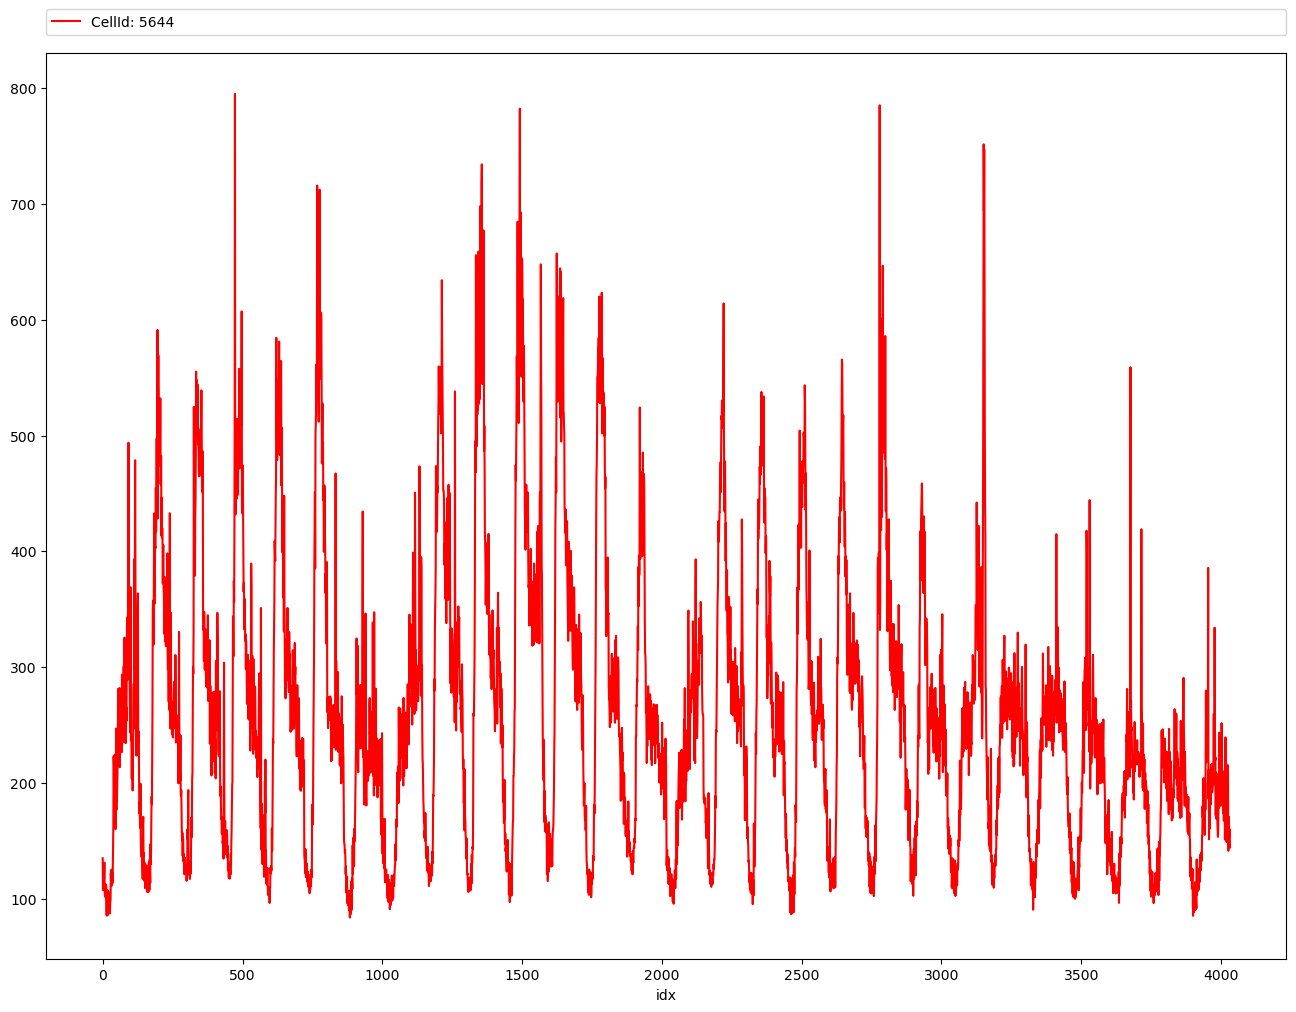

In [10]:
plt.figure(figsize=(16, 12), dpi=100) 

uni_data5644.plot(kind='line',x='index',y='internet', color='red', label = "CellId: 5644")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
plt.savefig('Prueba.png',bbox_inches='tight')

plt.show()

In [11]:
uni_data = uni_data5644

<AxesSubplot:xlabel='idx'>

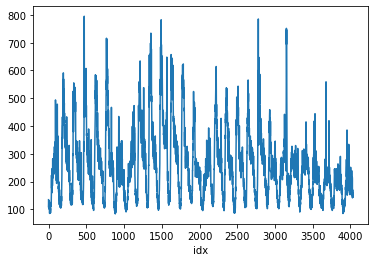

In [12]:
uni_data.plot()

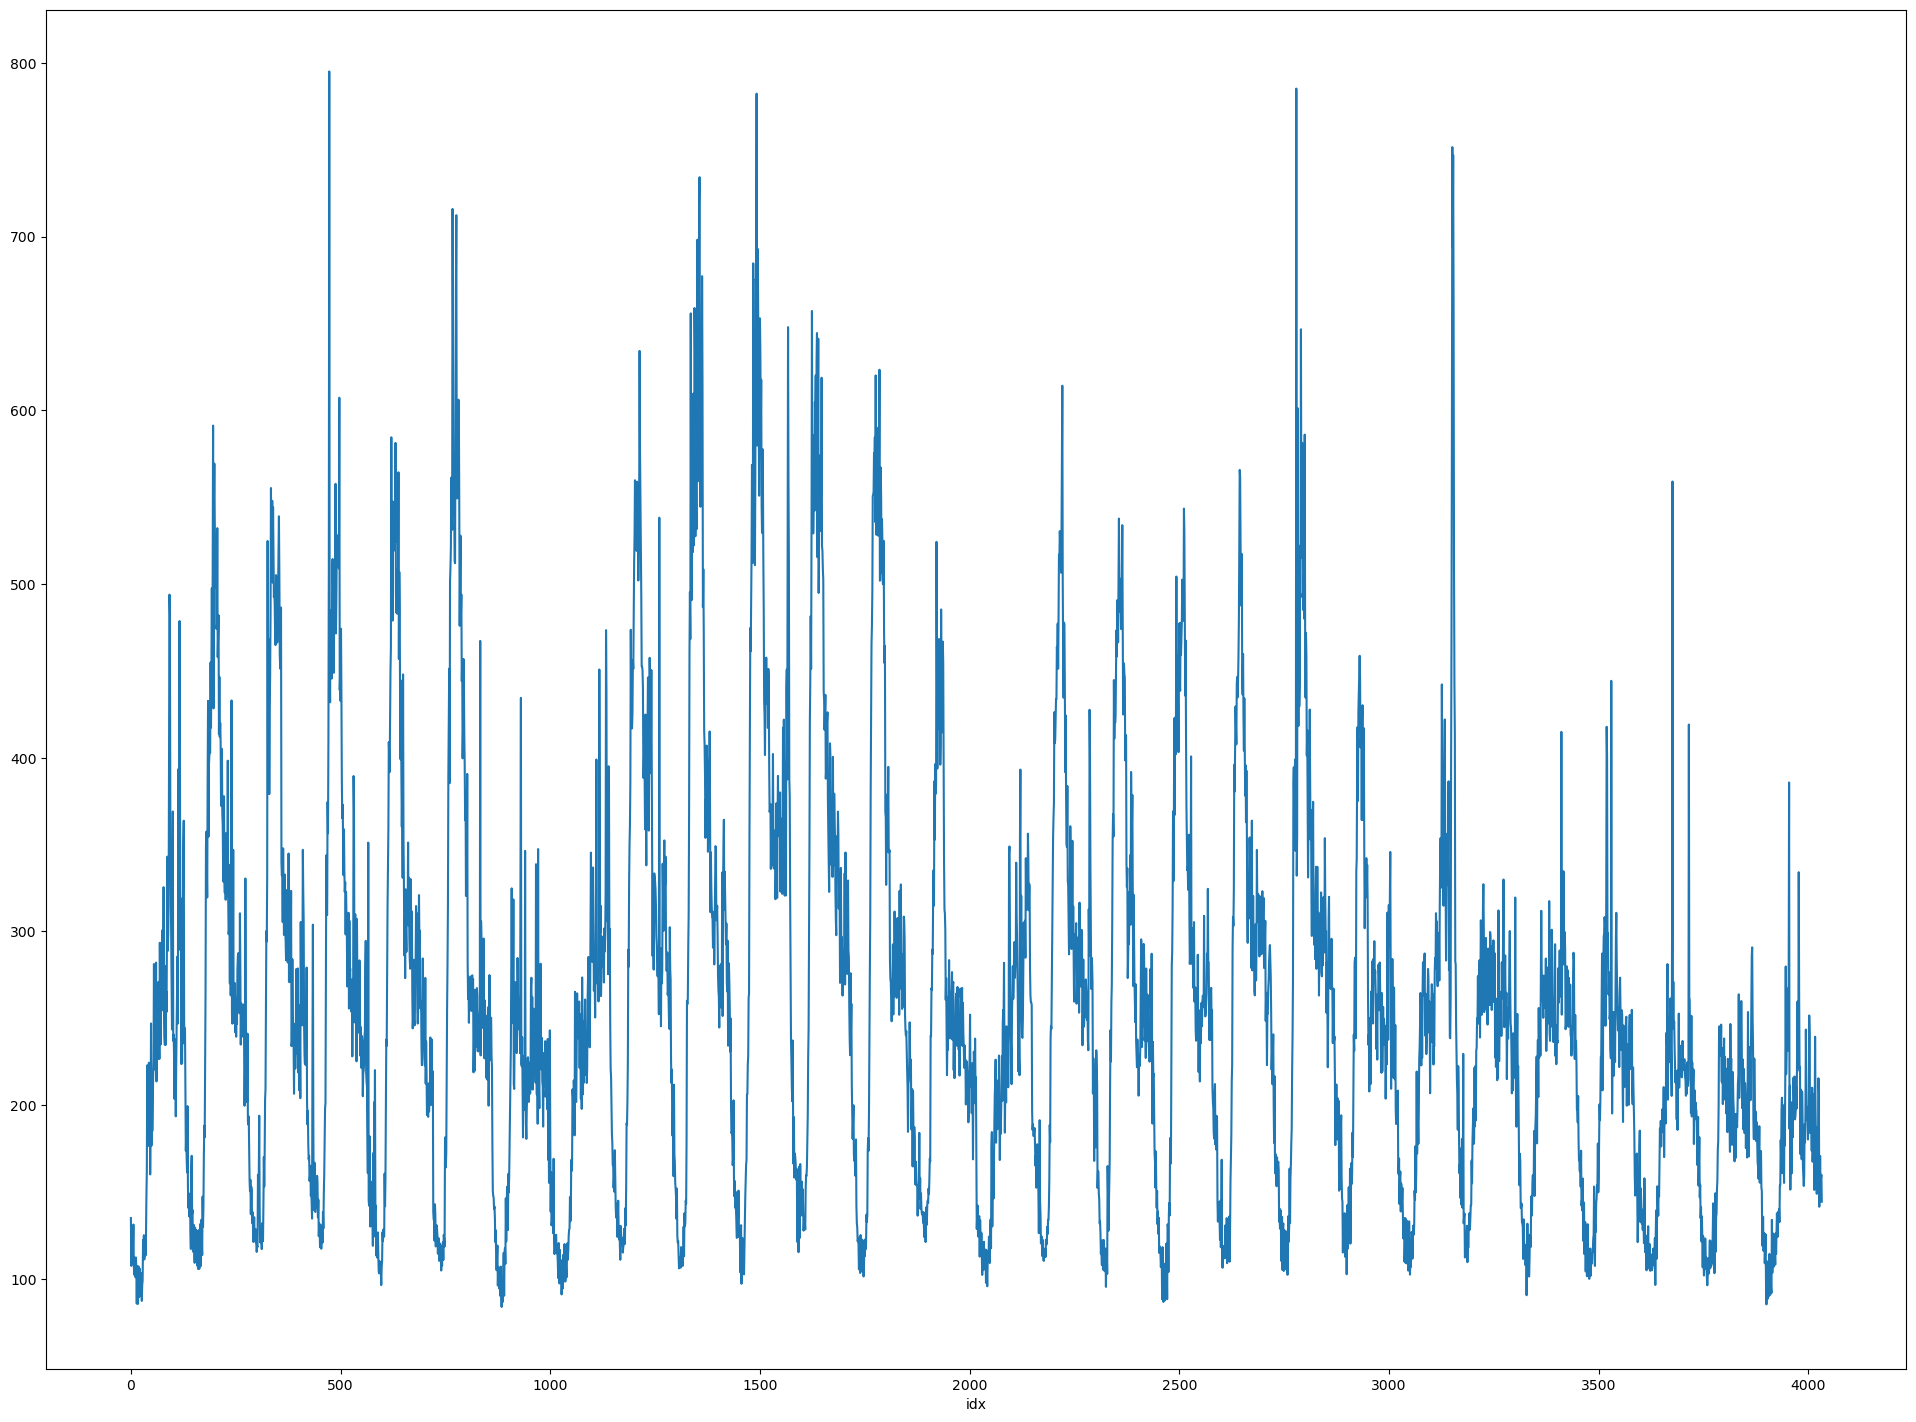

In [13]:
plt.figure(figsize=(24, 18), dpi=100) 
uni_data.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba5644.png',bbox_inches='tight')
plt.show()

In [14]:
uni_data

idx
0.0       135.029209
1.0       107.493371
2.0       116.361533
3.0       127.892932
4.0       110.755299
             ...    
4028.0    170.734492
4029.0    153.487745
4030.0    157.522089
4031.0    159.975281
4032.0    144.458604
Name: internet, Length: 4033, dtype: float64

In [15]:
uni_data = uni_data.values

In [16]:
uni_data

array([135.02920893, 107.49337135, 116.36153292, ..., 157.52208874,
       159.97528053, 144.45860365])

In [17]:
uni_data
len(uni_data)

4033

In [18]:
from sklearn.preprocessing import MinMaxScaler
feature = ['idx', 'internet']
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(dataMeteoCellId5644[feature])

In [19]:
uni_data = DataScaledMeteoCellId5644

In [20]:
uni_data

array([[0.00000000e+00, 7.19307606e-02],
       [2.48015873e-04, 3.32120867e-02],
       [4.96031746e-04, 4.56817802e-02],
       ...,
       [9.99503968e-01, 1.03558434e-01],
       [9.99751984e-01, 1.07007914e-01],
       [1.00000000e+00, 8.51896149e-02]])

In [21]:
uni_data[:,1]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [22]:
univariate_past_history = 6
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(uni_data[:,1], 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data[:,1], TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [23]:
len(x_train_uni)

2817

In [24]:
len(y_train_uni)

2817

In [25]:
len(x_val_uni)

1203

In [26]:
x_train_uni

array([[[0.07193076],
        [0.03321209],
        [0.04568178],
        [0.0618963 ],
        [0.03779875],
        [0.04907265]],

       [[0.03321209],
        [0.04568178],
        [0.0618963 ],
        [0.03779875],
        [0.04907265],
        [0.06671302]],

       [[0.04568178],
        [0.0618963 ],
        [0.03779875],
        [0.04907265],
        [0.06671302],
        [0.03359665]],

       ...,

       [[0.40235302],
        [0.33817173],
        [0.3003    ],
        [0.37908385],
        [0.36254675],
        [0.4088272 ]],

       [[0.33817173],
        [0.3003    ],
        [0.37908385],
        [0.36254675],
        [0.4088272 ],
        [0.32088927]],

       [[0.3003    ],
        [0.37908385],
        [0.36254675],
        [0.4088272 ],
        [0.32088927],
        [0.30988734]]])

In [27]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Internet charge to predict')
print (y_train_uni[0])

Single window of past history
[[0.07193076]
 [0.03321209]
 [0.04568178]
 [0.0618963 ]
 [0.03779875]
 [0.04907265]]

 Target Internet charge to predict
0.03359665147127812


In [28]:
def create_time_steps(length):
    return list(range(-length, 0))

In [29]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+3)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

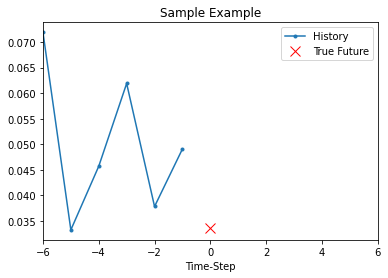

In [30]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

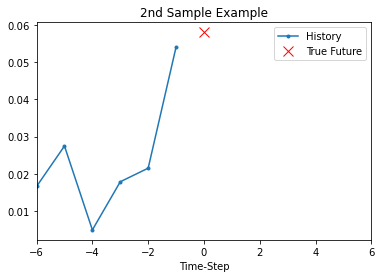

In [31]:
show_plot([x_train_uni[24], y_train_uni[24]], 0, '2nd Sample Example')

In [32]:
import requests

def telegram_bot_sendtext(bot_message):
    
    bot_token = '1441415905:AAGslC5ZnjlBYHnFYP-9KAH-BPAwnqJc1X4'
    bot_chatID = '1071238666'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message

    response = requests.get(send_text)

    return response.json()
    

test = telegram_bot_sendtext("VM Antigua reiniciada")
print(test)

{'ok': True, 'result': {'message_id': 710, 'from': {'id': 1441415905, 'is_bot': True, 'first_name': 'Tfmbot', 'username': 'Tfmdl_bot'}, 'chat': {'id': 1071238666, 'first_name': 'man', 'last_name': 'cham', 'username': 'mancham8', 'type': 'private'}, 'date': 1609765208, 'text': 'VM Antigua reiniciada'}}


# Baseline

In [32]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

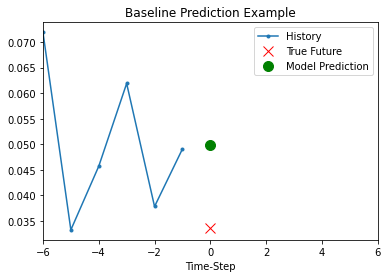

In [33]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

# Common constants

In [ ]:
VAL_OPTIMIZER = 'adam'
VAL_LOSS = 'mse'
VAL_METRICS = ['accuracy', 'mae', 'mse',tf.keras.metrics.RootMeanSquaredError()]
EPOCHS = 100
VAL_BATCH_SIZE = 16

# Recurrent neural network con la CellId 5644

In [ ]:
simple_lstm_model_5644 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model_5644.summary()

simple_lstm_model_5644.compile(optimizer=VAL_OPTIMIZER, loss=VAL_LOSS,metrics=VAL_METRICS)

In [ ]:
EPOCHS = 100

history_5644 = simple_lstm_model_5644.fit(x_train_uni, y_train_uni, epochs=EPOCHS,
                      batch_size=VAL_BATCH_SIZE,
                      validation_data=(x_val_uni, y_val_uni), verbose=1)

In [ ]:
for i in range (0,19):
    plot = show_plot([x_val_uni[i*5], y_val_uni[i*5],
                    simple_lstm_model_5644.predict(x_val_uni)[i*5]], 0, 'Simple LSTM model CellId 5644')
    plot.show()

In [ ]:
test_predictions_5644 = simple_lstm_model_5644.predict(x_val_uni).flatten()

plt.figure(figsize=(16, 12), dpi=100) 
a = plt.axes(aspect='equal')
plt.scatter(y_val_uni, test_predictions_5644)
plt.title('Prediction accuracy CellId 5644')
plt.xlabel('True Values [Internet]')
plt.ylabel('Predictions [Internet]')
xlims = [-2, 2]
ylims = [-2, 2]
plt.xlim(xlims)
plt.ylim(ylims)
_ = plt.plot(xlims, ylims)

In [ ]:
error = test_predictions_5644 - y_val_uni
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error [Internet]")
_ = plt.ylabel("Count")

In [ ]:
test_predictions_5644_batch_16 = simple_lstm_model_5644.predict(x_val_uni)

In [ ]:
#MSE
mse_5644_batch_16 = tf.keras.losses.MeanSquaredError()
mse_5644_batch_16(y_val_uni, test_predictions_5644_batch_16).numpy()

In [ ]:
#RMSE
rmse_5644_batch_16 = tf.keras.metrics.RootMeanSquaredError()
rmse_5644_batch_16(y_val_uni, test_predictions_5644_batch_16).numpy()

In [ ]:
#RMSE
rmse_5644_batch_16 = tf.keras.metrics.RootMeanSquaredError()
rmse_5644_batch_16.update_state(y_val_uni, test_predictions_5644_batch_16)
rmse_5644_batch_16.result().numpy()                                

## Cambio valores CellId 5644

#### Batch 8

In [ ]:
VAL_BATCH_SIZE_8 = 8
simple_lstm_model_5644_batch_8 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model_5644_batch_8.summary()

simple_lstm_model_5644_batch_8.compile(optimizer=VAL_OPTIMIZER , loss=VAL_LOSS ,metrics=VAL_METRICS)

In [ ]:
history_5644_batch_8 = simple_lstm_model_5644_batch_8.fit(x_train_uni, y_train_uni, epochs=EPOCHS,
                      batch_size=VAL_BATCH_SIZE_8,
                      validation_data=(x_val_uni, y_val_uni), verbose=1)

In [ ]:
history_5644_batch_8.history

In [ ]:
test_predictions_5644_batch_8 = simple_lstm_model_5644_batch_8.predict(x_val_uni)

mse_5644_batch_8 = tf.keras.losses.MeanSquaredError()
mse_5644_batch_8(y_val_uni, test_predictions_5644_batch_8).numpy()

In [ ]:
#RMSE
mse_5644_batch_8 = tf.keras.metrics.RootMeanSquaredError()
mse_5644_batch_8(y_val_uni, test_predictions_5644_batch_8).numpy()

In [ ]:
history_dict_5644_batch_8 = history_5644_batch_8.history
mse_values = history_dict_5644_batch_8['mse']
val_mse_values_5644_batch_8 = history_dict_5644_batch_8['val_mse']
epochs = range(1, len(val_mse_values_5644_batch_8) + 1)

%matplotlib inline 

plt.figure(figsize=(16, 12), dpi=100) 
plt.plot(epochs, history_5644_batch_8.history['mse'], 'rx', label='Training data')
plt.plot(epochs, val_mse_values_5644_batch_8, 'b', label='Test data')
plt.title('Training and test MSE CellId 5644 Batch 8')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### Batch 32

In [ ]:
simple_lstm_model_5644_batch_32 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model_5644_batch_32.summary()

simple_lstm_model_5644_batch_32.compile(optimizer=VAL_OPTIMIZER, loss=VAL_LOSS,metrics=VAL_METRICS)

In [ ]:
history_5644_batch_32 = simple_lstm_model_5644_batch_32.fit(x_train_uni, y_train_uni, epochs=EPOCHS,
                      batch_size=32,
                      validation_data=(x_val_uni, y_val_uni), verbose=1)

In [ ]:
test_predictions_5644_batch_32 = simple_lstm_model_5644_batch_32.predict(x_val_uni)

mse_5644_batch_32 = tf.keras.losses.MeanSquaredError()
mse_5644_batch_32(y_val_uni, test_predictions_5644_batch_32).numpy()

In [ ]:
#RMSE
mse_5644_batch_32 = tf.keras.metrics.RootMeanSquaredError()
mse_5644_batch_32(y_val_uni, test_predictions_5644_batch_32).numpy()

In [ ]:
history_dict_5644_batch_32 = history_5644_batch_32.history
mse_values = history_dict_5644_batch_32['mse']
val_mse_values_5644_batch_32 = history_dict_5644_batch_32['val_mse']
epochs = range(1, len(val_mse_values_5644_batch_32) + 1)

%matplotlib inline 

plt.figure(figsize=(16, 12), dpi=100) 
plt.plot(epochs, history_5644_batch_32.history['mse'], 'rx', label='Training data')
plt.plot(epochs, val_mse_values_5644_batch_32, 'b', label='Test data')
plt.title('Training and test MSE CellId 5644 Batch 32')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### Batch 64

In [ ]:
simple_lstm_model_5644_batch_64 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model_5644_batch_64.summary()

simple_lstm_model_5644_batch_64.compile(optimizer=VAL_OPTIMIZER, loss=VAL_LOSS ,metrics=VAL_METRICS )

In [ ]:
history_5644_batch_64 = simple_lstm_model_5644_batch_64.fit(x_train_uni, y_train_uni, epochs=EPOCHS,
                      batch_size=64,
                      validation_data=(x_val_uni, y_val_uni), verbose=1)

In [ ]:
test_predictions_5644_batch_64 = simple_lstm_model_5644_batch_64.predict(x_val_uni)

mse_5644_batch_64 = tf.keras.losses.MeanSquaredError()
mse_5644_batch_64(y_val_uni, test_predictions_5644_batch_64).numpy()

In [ ]:
#RMSE
mse_5644_batch_64 = tf.keras.metrics.RootMeanSquaredError()
mse_5644_batch_64(y_val_uni, test_predictions_5644_batch_64).numpy()

In [ ]:
history_dict_5644_batch_64 = history_5644_batch_64.history
mse_values = history_dict_5644_batch_64['mse']
val_mse_values_5644_batch_64 = history_dict_5644_batch_64['val_mse']
epochs = range(1, len(val_mse_values_5644_batch_64) + 1)

%matplotlib inline 

plt.figure(figsize=(16, 12), dpi=100) 
plt.plot(epochs, history_5644_batch_64.history['mse'], 'rx', label='Training data')
plt.plot(epochs, val_mse_values_5644_batch_64, 'b', label='Test data')
plt.title('Training and test MSE CellId 5644 Batch 64')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### Batch 128

In [ ]:
simple_lstm_model_5644_batch_128 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model_5644_batch_128.summary()

simple_lstm_model_5644_batch_128.compile(optimizer=VAL_OPTIMIZER, loss=VAL_LOSS ,metrics=VAL_METRICS )

In [ ]:
history_5644_batch_128 = simple_lstm_model_5644_batch_128.fit(x_train_uni, y_train_uni, epochs=EPOCHS,
                      batch_size=128,
                      validation_data=(x_val_uni, y_val_uni), verbose=1)

In [ ]:
test_predictions_5644_batch_128 = simple_lstm_model_5644_batch_128.predict(x_val_uni)

mse_5644_batch_128 = tf.keras.losses.MeanSquaredError()
mse_5644_batch_128(y_val_uni, test_predictions_5644_batch_128).numpy()

In [ ]:
#RMSE
mse_5644_batch_128 = tf.keras.metrics.RootMeanSquaredError()
mse_5644_batch_128(y_val_uni, test_predictions_5644_batch_128).numpy()

In [ ]:
history_dict_5644_batch_128 = history_5644_batch_128.history
mse_values = history_dict_5644_batch_128['mse']
val_mse_values_5644_batch_128 = history_dict_5644_batch_128['val_mse']
epochs = range(1, len(val_mse_values_5644_batch_128) + 1)

%matplotlib inline 

plt.figure(figsize=(16, 12), dpi=100) 
plt.plot(epochs, history_5644_batch_128.history['mse'], 'rx', label='Training data')
plt.plot(epochs, val_mse_values_5644_batch_128, 'b', label='Test data')
plt.title('Training and test MSE CellId 5644 Batch 128')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### Batch 256

In [ ]:
simple_lstm_model_5644_batch_256 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model_5644_batch_256.summary()

simple_lstm_model_5644_batch_256.compile(optimizer=VAL_OPTIMIZER, loss=VAL_LOSS ,metrics=VAL_METRICS )

In [ ]:
history_5644_batch_256 = simple_lstm_model_5644_batch_256.fit(x_train_uni, y_train_uni, epochs=EPOCHS,
                      batch_size=256,
                      validation_data=(x_val_uni, y_val_uni), verbose=1)

In [ ]:
test_predictions_5644_batch_256 = simple_lstm_model_5644_batch_256.predict(x_val_uni)

mse_5644_batch_256 = tf.keras.losses.MeanSquaredError()
mse_5644_batch_256(y_val_uni, test_predictions_5644_batch_256).numpy()

In [ ]:
#RMSE
mse_5644_batch_256 = tf.keras.metrics.RootMeanSquaredError()
mse_5644_batch_256(y_val_uni, test_predictions_5644_batch_256).numpy()

In [ ]:
history_dict_5644_batch_256 = history_5644_batch_256.history
mse_values = history_dict_5644_batch_256['mse']
val_mse_values_5644_batch_256 = history_dict_5644_batch_256['val_mse']
epochs = range(1, len(val_mse_values_5644_batch_256) + 1)

%matplotlib inline 

plt.figure(figsize=(16, 12), dpi=100) 
plt.plot(epochs, history_5644_batch_256.history['mse'], 'rx', label='Training data')
plt.plot(epochs, val_mse_values_5644_batch_256, 'b', label='Test data')
plt.title('Training and test MSE CellId 5644 Batch 256')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### Batch 512

In [ ]:
simple_lstm_model_5644_batch_512 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model_5644_batch_512.summary()

simple_lstm_model_5644_batch_512.compile(optimizer=VAL_OPTIMIZER , loss=VAL_LOSS ,metrics=VAL_METRICS )

In [ ]:
EPOCHS = 100

history_5644_batch_512 = simple_lstm_model_5644_batch_512.fit(x_train_uni, y_train_uni, epochs=EPOCHS,
                      batch_size=512,
                      validation_data=(x_val_uni, y_val_uni), verbose=1)

In [ ]:
test_predictions_5644_batch_512 = simple_lstm_model_5644_batch_512.predict(x_val_uni)

mse_5644_batch_512 = tf.keras.losses.MeanSquaredError()
mse_5644_batch_512(y_val_uni, test_predictions_5644_batch_512).numpy()

In [ ]:
#RMSE
mse_5644_batch_512 = tf.keras.metrics.RootMeanSquaredError()
mse_5644_batch_512(y_val_uni, test_predictions_5644_batch_512).numpy()

In [ ]:
history_dict_5644_batch_512 = history_5644_batch_512.history
mse_values = history_dict_5644_batch_512['mse']
val_mse_values_5644_batch_512 = history_dict_5644_batch_512['val_mse']
epochs = range(1, len(val_mse_values_5644_batch_512) + 1)

%matplotlib inline 

plt.figure(figsize=(16, 12), dpi=100) 
plt.plot(epochs, history_5644_batch_512.history['mse'], 'rx', label='Training data')
plt.plot(epochs, val_mse_values_5644_batch_512, 'b', label='Test data')
plt.title('Training and test MSE CellId 5644 Batch 512')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### Batch 1024

In [ ]:
simple_lstm_model_5644_batch_1024 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model_5644_batch_1024.summary()

simple_lstm_model_5644_batch_1024.compile(optimizer=VAL_OPTIMIZER , loss=VAL_LOSS ,metrics=VAL_METRICS )

In [ ]:
EPOCHS = 100

history_5644_batch_1024 = simple_lstm_model_5644_batch_1024.fit(x_train_uni, y_train_uni, epochs=EPOCHS,
                      batch_size=1024,
                      validation_data=(x_val_uni, y_val_uni), verbose=1)

In [ ]:
test_predictions_5644_batch_1024 = simple_lstm_model_5644_batch_1024.predict(x_val_uni)

mse_5644_batch_1024 = tf.keras.losses.MeanSquaredError()
mse_5644_batch_1024(y_val_uni, test_predictions_5644_batch_1024).numpy()

In [ ]:
#RMSE
mse_5644_batch_1024 = tf.keras.metrics.RootMeanSquaredError()
mse_5644_batch_1024(y_val_uni, test_predictions_5644_batch_1024).numpy()

In [ ]:
history_dict_5644_batch_1024 = history_5644_batch_1024.history
mse_values = history_dict_5644_batch_1024['mse']
val_mse_values_5644_batch_1024 = history_dict_5644_batch_1024['val_mse']
epochs = range(1, len(val_mse_values_5644_batch_1024) + 1)

%matplotlib inline 

plt.figure(figsize=(16, 12), dpi=100) 
plt.plot(epochs, history_5644_batch_1024.history['mse'], 'rx', label='Training data')
plt.plot(epochs, val_mse_values_5644_batch_1024, 'b', label='Test data')
plt.title('Training and test MSE CellId 5644 Batch 1024')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

#### Batch Comparation

In [ ]:
plt.figure(figsize=(16, 12), dpi=100) 

plt.plot(epochs, history_dict_5644_batch_8['root_mean_squared_error'], 'red', label='Batch 8 Training data')
plt.plot(epochs, history_dict_5644_batch_8['val_root_mean_squared_error'], 'rx', label='Batch 8 Validation data')
plt.plot(epochs, history_5644.history['root_mean_squared_error'], 'blue', label='Batch 16 Training data')
plt.plot(epochs, history_5644.history['val_root_mean_squared_error'], 'bx', label='Batch 16 Validation data')
plt.plot(epochs, history_dict_5644_batch_32['root_mean_squared_error'], 'red', label='Batch 32 Training data')
plt.plot(epochs, history_dict_5644_batch_32['val_root_mean_squared_error'], 'rx', label='Batch 32 Validation data')
plt.plot(epochs, history_dict_5644_batch_64['root_mean_squared_error'], 'green', label='Batch 64 Training data')
plt.plot(epochs, history_dict_5644_batch_64['val_root_mean_squared_error'], 'gx', label='Batch 64 Validation data')
plt.plot(epochs, history_dict_5644_batch_128['root_mean_squared_error'], 'orange', label='Batch 128 Training data')
plt.plot(epochs, history_dict_5644_batch_128['val_root_mean_squared_error'], 'x', color = 'orange', label='Batch 128 Validation data')
plt.plot(epochs, history_dict_5644_batch_256['root_mean_squared_error'], 'black', label='Batch 256 Training data')
plt.plot(epochs, history_dict_5644_batch_256['val_root_mean_squared_error'], 'kx', label='Batch 256 Validation data')
plt.plot(epochs, history_dict_5644_batch_512['root_mean_squared_error'], 'pink', label='Batch 512 Training data')
plt.plot(epochs, history_dict_5644_batch_512['val_root_mean_squared_error'], 'x', color='pink', label='Batch 512 Validation data')
plt.plot(epochs, history_dict_5644_batch_1024['root_mean_squared_error'], 'cyan', label='Batch 1024 Training data')
plt.plot(epochs, history_dict_5644_batch_1024['val_root_mean_squared_error'], 'cx', label='Batch 1024 Validation data')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
plt.savefig('transformed_data/images/RMSEComparation_5644.png',bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(16, 12), dpi=100) 

plt.plot(epochs, history_dict_5644_batch_8['mse'], 'red', label='Batch 8 Training data')
plt.plot(epochs, history_dict_5644_batch_8['val_mse'], 'rx', label='Batch 8 Validation data')
plt.plot(epochs, history_5644.history['mse'], 'blue', label='Batch 16 Training data')
plt.plot(epochs, history_5644.history['val_mse'], 'bx', label='Batch 16 Validation data')
plt.plot(epochs, history_dict_5644_batch_32['mse'], 'red', label='Batch 32 Training data')
plt.plot(epochs, history_dict_5644_batch_32['val_mse'], 'rx', label='Batch 32 Validation data')
plt.plot(epochs, history_dict_5644_batch_64['mse'], 'green', label='Batch 64 Training data')
plt.plot(epochs, history_dict_5644_batch_64['val_mse'], 'gx', label='Batch 64 Validation data')
plt.plot(epochs, history_dict_5644_batch_128['mse'], 'orange', label='Batch 128 Training data')
plt.plot(epochs, history_dict_5644_batch_128['val_mse'], 'x', color = 'orange', label='Batch 128 Validation data')
plt.plot(epochs, history_dict_5644_batch_256['mse'], 'black', label='Batch 256 Training data')
plt.plot(epochs, history_dict_5644_batch_256['val_mse'], 'kx', label='Batch 256 Validation data')
plt.plot(epochs, history_dict_5644_batch_512['mse'], 'pink', label='Batch 512 Training data')
plt.plot(epochs, history_dict_5644_batch_512['val_mse'], 'x', color='pink', label='Batch 512 Validation data')
plt.plot(epochs, history_dict_5644_batch_1024['mse'], 'cyan', label='Batch 1024 Training data')
plt.plot(epochs, history_dict_5644_batch_1024['val_mse'], 'cx', label='Batch 1024 Validation data')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
plt.savefig('transformed_data/images/MSEComparation_5644.png',bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(16, 12), dpi=100) 

plt.plot(epochs, history_dict_5644_batch_8['loss'], 'red', label='Batch 8 Training data')
plt.plot(epochs, history_dict_5644_batch_8['val_loss'], 'rx', label='Batch 8 Validation data')
plt.plot(epochs, history_5644.history['loss'], 'blue', label='Batch 16 Training data')
plt.plot(epochs, history_5644.history['val_loss'], 'bx', label='Batch 16 Validation data')
plt.plot(epochs, history_dict_5644_batch_32['loss'], 'red', label='Batch 32 Training data')
plt.plot(epochs, history_dict_5644_batch_32['val_loss'], 'rx', label='Batch 32 Validation data')
plt.plot(epochs, history_dict_5644_batch_64['loss'], 'green', label='Batch 64 Training data')
plt.plot(epochs, history_dict_5644_batch_64['val_loss'], 'gx', label='Batch 64 Validation data')
plt.plot(epochs, history_dict_5644_batch_128['loss'], 'orange', label='Batch 128 Training data')
plt.plot(epochs, history_dict_5644_batch_128['val_loss'], 'x', color = 'orange', label='Batch 128 Validation data')
plt.plot(epochs, history_dict_5644_batch_256['loss'], 'black', label='Batch 256 Training data')
plt.plot(epochs, history_dict_5644_batch_256['val_loss'], 'kx', label='Batch 256 Validation data')
plt.plot(epochs, history_dict_5644_batch_512['loss'], 'pink', label='Batch 512 Training data')
plt.plot(epochs, history_dict_5644_batch_512['val_loss'], 'x', color='pink', label='Batch 512 Validation data')
plt.plot(epochs, history_dict_5644_batch_1024['loss'], 'cyan', label='Batch 1024 Training data')
plt.plot(epochs, history_dict_5644_batch_1024['val_loss'], 'cx', label='Batch 1024 Validation data')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
plt.savefig('transformed_data/images/LossComparation_5644.png',bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(16, 12), dpi=100) 

plt.plot(epochs, history_dict_5644_batch_8['mae'], 'red', label='Batch 8 Training data')
plt.plot(epochs, history_dict_5644_batch_8['val_mae'], 'rx', label='Batch 8 Validation data')
plt.plot(epochs, history_5644.history['mae'], 'blue', label='Batch 16 Training data')
plt.plot(epochs, history_5644.history['val_mae'], 'bx', label='Batch 16 Validation data')
plt.plot(epochs, history_dict_5644_batch_32['mae'], 'red', label='Batch 32 Training data')
plt.plot(epochs, history_dict_5644_batch_32['val_mae'], 'rx', label='Batch 32 Validation data')
plt.plot(epochs, history_dict_5644_batch_64['mae'], 'green', label='Batch 64 Training data')
plt.plot(epochs, history_dict_5644_batch_64['val_mae'], 'gx', label='Batch 64 Validation data')
plt.plot(epochs, history_dict_5644_batch_128['mae'], 'orange', label='Batch 128 Training data')
plt.plot(epochs, history_dict_5644_batch_128['val_mae'], 'x', color = 'orange', label='Batch 128 Validation data')
plt.plot(epochs, history_dict_5644_batch_256['mae'], 'black', label='Batch 256 Training data')
plt.plot(epochs, history_dict_5644_batch_256['val_mae'], 'kx', label='Batch 256 Validation data')
plt.plot(epochs, history_dict_5644_batch_512['mae'], 'pink', label='Batch 512 Training data')
plt.plot(epochs, history_dict_5644_batch_512['val_mae'], 'x', color='pink', label='Batch 512 Validation data')
plt.plot(epochs, history_dict_5644_batch_1024['mae'], 'cyan', label='Batch 1024 Training data')
plt.plot(epochs, history_dict_5644_batch_1024['val_mae'], 'cx', label='Batch 1024 Validation data')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
plt.savefig('transformed_data/images/MaeComparation_5644.png',bbox_inches='tight')

plt.show()

# Recurrent neural network con cambio de variables con la CellId 5644 -LSTM

In [ ]:
EPOCHS = [10, 20, 30, 40, 50, 75, 100, 200]
BATCH_SIZE = [8, 16, 16,32,64,128,256, 512, 1024]
NODOS = [8, 16, 32, 64, 128]

model5644Array = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            print ("epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo))
            simple_lstm = tf.keras.models.Sequential([
                tf.keras.layers.LSTM(nodo, input_shape=x_train_uni_cellId[1].shape[-2:]),
                tf.keras.layers.Dense(1)
            ])

            simple_lstm.summary()

            simple_lstm.compile(optimizer='adam', loss='mae',metrics=['accuracy'])

            history_lstm = simple_lstm.fit(x_train_uni_cellId[1], y_train_uni_cellId[1], epochs=epoch,
                          batch_size=batch,
                          validation_data=(x_val_uni_cellId[1], y_val_uni_cellId[1]), verbose=1)
    
            model5644Array.append ([epoch, batch, nodo, simple_lstm, history_lstm])

In [ ]:
model5644Array

In [ ]:
model5644ArrayAcc = []
for model in model5644Array:
    score = model[3].evaluate(x_train_uni_cellId[1], y_train_uni_cellId[1], verbose=0)
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]))
    print('Keras Model Loss = ',score[0])
    print('Keras Model Accuracy = ',score[1])
    model5644Array.append ([model[0], model[1], model[2], score])

In [ ]:
for model in model5644Array:
    TrainPred = model[3].predict(x_train_uni_cellId[1])
    TestPred = model.predict(x_val_uni_cellId[1])
    TrainPred = scaler.inverse_transform(TrainPred)
    TrainY = scaler.inverse_transform([y_train_uni_cellId[1]])
    TestPred = scaler.inverse_transform(TestPred)
    TestY = scaler.inverse_transform([y_val_uni_cellId[1]])
    TrainPredictPlot = np.empty_like(TRAIN_SPLIT)
    TrainPredictPlot[:, :] = np.nan
    TrainPredictPlot[1:len(TrainPred)+1, :] = TrainPred
    TestPredictPlot = np.empty_like(TRAIN_SPLIT)
    TestPredictPlot[:, :] = np.nan
    TestPredictPlot[len(TrainPred)+(1*2)+1:len(DataScaled)-1, :] = TestPred
    plt.figure(figsize=(10,5))
    plt.plot(scaler.inverse_transform(DataScaled))
    plt.plot(TrainPredictPlot)
    plt.plot(TestPredictPlot)
    plt.show()

In [ ]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5644Array = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[2])
                simple_lstm = tf.keras.models.Sequential()
                simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                for x in range (layer-1):
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)

                model5644Array.append ([epoch, batch, nodo, layer, LEARNINGRATE[2], simple_lstm, history_lstm])
                if (i % 60 == 0):
                    test = telegram_bot_sendtext(str(i) + ". VM Antigua creado: " + msg)
                i = i + 1

In [ ]:
len(model5644Array)

In [ ]:
model5644ArrayAcc = []
for model in model5644Array:
    score = model[5].evaluate(x_train_uni, y_train_uni, verbose=0)
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]) + "layer: " + str(model[3]) + "learning rate: " + str(model[4]))
    print('Keras Model Loss = ',score[0])
    print('Keras Model Accuracy = ',score[1])
    model5644ArrayAcc.append ([model[0], model[1], model[2], model[3], model[4], score[0], score[1]])

In [ ]:
model5644ArrayAcc

In [ ]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileLstmUni = 'transformed_data/model5644-6-0-1-acc_LSTM_3.csv'
dfModel5644ArrayAcc.to_csv(fileLstmUni, encoding='utf-8')

In [ ]:
#test_predictions_5459_batch_32 = simple_lstm_model_5459_batch_32.predict(x_val_uni_cellId[0])

#mse_5459_batch_32 = tf.keras.losses.MeanSquaredError()
#mse_5459_batch_32(y_val_uni_cellId[0], test_predictions_5459_batch_32).numpy()

In [ ]:
#RMSE
#mse_5459_batch_32 = tf.keras.metrics.RootMeanSquaredError()
#mse_5459_batch_32(y_val_uni_cellId[0], test_predictions_5459_batch_32).numpy()

In [ ]:
model5644mse = []
for model in model5644Array:
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]) + "layer: " + str(model[3]) + "learning rate: " + str(model[4]))
    test_predictions = model[5].predict(x_val_uni)
    mse = tf.keras.losses.MeanSquaredError()
    dmse = mse(y_val_uni, test_predictions).numpy()
    #RMSE
    rmse = tf.keras.metrics.RootMeanSquaredError()
    drmse = rmse(y_val_uni, test_predictions).numpy()
    model5644mse.append ([model[0], model[1], model[2], model[3], model[4], dmse, drmse])

In [ ]:
len(model5644mse)

In [ ]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileLstmUni2 = 'transformed_data/model5644-6-0-1-mse_LSTM_3.csv'
dfModel5644mse.to_csv(fileLstmUni2, encoding='utf-8')

In [ ]:
for i in range (0,19):
    plot = show_plot([x_val_uni_cellId[1][i*5], y_val_uni_cellId[1][i*5],
                    simple_lstm_model_5644.predict(x_val_uni_cellId[1])[i*5]], 0, 'Simple LSTM model CellId 5644')
    plot.show()

In [ ]:
test_predictions_5644 = simple_lstm_model_5644.predict(x_val_uni_cellId[1]).flatten()

plt.figure(figsize=(16, 12), dpi=100) 
a = plt.axes(aspect='equal')
plt.scatter(y_val_uni_cellId[1], test_predictions_5644)
plt.title('Prediction accuracy CellId 5644')
plt.xlabel('True Values [Internet]')
plt.ylabel('Predictions [Internet]')
xlims = [-2, 2]
ylims = [-2, 2]
plt.xlim(xlims)
plt.ylim(ylims)
_ = plt.plot(xlims, ylims)

In [ ]:
error = test_predictions_5644 - y_val_uni_cellId[1]
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error [Internet]")
_ = plt.ylabel("Count")

# Recurrent neural network con cambio de variables con la CellId 5644 - GRU

In [ ]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5644Array = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[2])
                simple_lstm = tf.keras.models.Sequential()
                simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                for x in range (layer-1):
                    simple_lstm.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)

                model5644Array.append ([epoch, batch, nodo, layer, LEARNINGRATE[2], simple_lstm, history_lstm])
                if (i % 60 == 0):
                    test = telegram_bot_sendtext(str(i) + ". VM Antigua creado: " + msg)
                i = i + 1

In [ ]:
len(model5644Array)

In [ ]:
model5644ArrayAcc = []
for model in model5644Array:
    score = model[5].evaluate(x_train_uni, y_train_uni, verbose=0)
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]) + "layer: " + str(model[3]) + "learning rate: " + str(model[4]))
    print('Keras Model Loss = ',score[0])
    print('Keras Model Accuracy = ',score[1])
    model5644ArrayAcc.append ([model[0], model[1], model[2], model[3], model[4], score[0], score[1]])

In [ ]:
model5644ArrayAcc

In [ ]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileGruUni = 'transformed_data/model5644-6-0-1-acc_GRU_3.csv'
dfModel5644ArrayAcc.to_csv(fileGruUni, encoding='utf-8')

In [ ]:
#test_predictions_5459_batch_32 = simple_lstm_model_5459_batch_32.predict(x_val_uni_cellId[0])

#mse_5459_batch_32 = tf.keras.losses.MeanSquaredError()
#mse_5459_batch_32(y_val_uni_cellId[0], test_predictions_5459_batch_32).numpy()

In [ ]:
#RMSE
#mse_5459_batch_32 = tf.keras.metrics.RootMeanSquaredError()
#mse_5459_batch_32(y_val_uni_cellId[0], test_predictions_5459_batch_32).numpy()

In [ ]:
model5644mse = []
for model in model5644Array:
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]) + "layer: " + str(model[3]) + "learning rate: " + str(model[4]))
    test_predictions = model[5].predict(x_val_uni)
    mse = tf.keras.losses.MeanSquaredError()
    dmse = mse(y_val_uni, test_predictions).numpy()
    #RMSE
    rmse = tf.keras.metrics.RootMeanSquaredError()
    drmse = rmse(y_val_uni, test_predictions).numpy()
    model5644mse.append ([model[0], model[1], model[2], model[3], model[4], dmse, drmse])

In [ ]:
len(model5644mse)

In [ ]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileGruUni2 = 'transformed_data/model5644-6-0-1-mse_GRU_3.csv'
dfModel5644mse.to_csv(fileGruUni2, encoding='utf-8')

# Recurrent neural network con cambio de variables con la CellId 5644 multivariate time series

In [33]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'NO', 'NO2', 'CO','internet'] #		temperature	windSpeed

In [34]:
multi_data5644 = dataMeteoCellId5644[features_considered]
multi_data5644.index = dataMeteoCellId5644['idx'] - dataMeteoCellId5644['idx'].values[0]
multi_data5644.head()

,temperature,relativeHumidity,precipitation,windSpeed,NO,NO2,CO,internet
idx,,,,,,,,
0.0,-0.200000,99.0,0.0,0.366667,124.500000,57.900000,1.200000,135.029209
1.0,-0.283333,99.0,0.0,0.405556,124.683333,58.866667,1.216667,107.493371
2.0,-0.366667,99.0,0.0,0.444444,124.866667,59.833333,1.233333,116.361533
3.0,-0.450000,99.0,0.0,0.483333,125.050000,60.800000,1.250000,127.892932
4.0,-0.533333,99.0,0.0,0.522222,125.233333,61.766667,1.266667,110.755299


In [73]:
multi_data5644.loc[multi_data5644.relativeHumidity < 30, "relativeHumidity"] = 30

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
multi_data5644['relativeHumidity'].min

<bound method Series.min of idx
0.0       99.0
1.0       99.0
2.0       99.0
3.0       99.0
4.0       99.0
          ... 
4028.0    99.0
4029.0    99.0
4030.0    99.0
4031.0    99.0
4032.0    99.0
Name: relativeHumidity, Length: 4033, dtype: float64>

In [74]:
multi_data5644[multi_data5644['relativeHumidity'] < 30]

,temperature,relativeHumidity,precipitation,windSpeed,NO,NO2,CO,internet
idx,,,,,,,,


In [60]:
multi_data5644.loc[multi_data5644.NO < -5, "NO"] = 0

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
multi_data5644[multi_data5644['NO'] < -5]

,temperature,relativeHumidity,precipitation,windSpeed,NO,NO2,CO,internet
idx,,,,,,,,


In [34]:
len(multi_data5644)

4033

In [35]:
#features = dataMeteoCellId[features_considered]
#features.index = dataMeteoCellId['hour'] + dataMeteoCellId['weekday'] * 24 + (dataMeteoCellId['week'] - 48) * 24 * 7
#features.head()

In [75]:
dataset = multi_data5644.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

<Figure size 2400x1800 with 0 Axes>

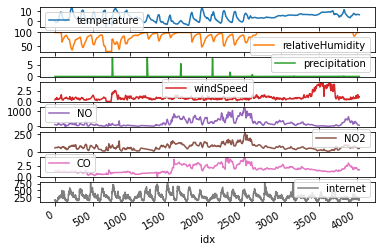

In [76]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5644.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba5644_1.png',bbox_inches='tight')
plt.show()

In [38]:
multi_data5644

,temperature,relativeHumidity,precipitation,windSpeed,NO,NO2,CO,internet
idx,,,,,,,,
0.0,-0.200000,99.0,0.0,0.366667,124.500000,57.900000,1.200000,135.029209
1.0,-0.283333,99.0,0.0,0.405556,124.683333,58.866667,1.216667,107.493371
2.0,-0.366667,99.0,0.0,0.444444,124.866667,59.833333,1.233333,116.361533
3.0,-0.450000,99.0,0.0,0.483333,125.050000,60.800000,1.250000,127.892932
4.0,-0.533333,99.0,0.0,0.522222,125.233333,61.766667,1.266667,110.755299
...,...,...,...,...,...,...,...,...
4028.0,6.733333,99.0,0.0,1.100000,88.500000,51.700000,1.500000,170.734492
4029.0,6.700000,99.0,0.0,1.100000,86.500000,51.950000,1.500000,153.487745
4030.0,6.666667,99.0,0.0,1.100000,84.500000,52.200000,1.500000,157.522089


In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(multi_data5644)

In [40]:
dataset = DataScaledMeteoCellId5644

In [41]:
dataset

array([[0.67963387, 1.        , 0.        , ..., 0.18369647, 0.99968011,
        0.07193076],
       [0.67772693, 1.        , 0.        , ..., 0.18732782, 0.99968177,
        0.03321209],
       [0.67581998, 1.        , 0.        , ..., 0.19095918, 0.99968344,
        0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , ..., 0.162284  , 0.9997101 ,
        0.10355843],
       [0.83600305, 1.        , 0.        , ..., 0.16322314, 0.9997101 ,
        0.10700791],
       [0.83524027, 1.        , 0.        , ..., 0.16416228, 0.9997101 ,
        0.08518961]])

In [42]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [43]:
dataset[:, 7]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [44]:
dataset[:, [0,1,2,3,4,5,6]] #sep - dataset[:, [0,1,2,3]]

array([[0.67963387, 1.        , 0.        , ..., 0.89898766, 0.18369647,
        0.99968011],
       [0.67772693, 1.        , 0.        , ..., 0.89900394, 0.18732782,
        0.99968177],
       [0.67581998, 1.        , 0.        , ..., 0.89902022, 0.19095918,
        0.99968344],
       ...,
       [0.83676583, 1.        , 0.        , ..., 0.89543557, 0.162284  ,
        0.9997101 ],
       [0.83600305, 1.        , 0.        , ..., 0.89525797, 0.16322314,
        0.9997101 ],
       [0.83524027, 1.        , 0.        , ..., 0.89508037, 0.16416228,
        0.9997101 ]])

In [45]:
#univariate_past_history = 6
#univariate_future_target = 1
past_history = 6
future_target = 1
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset[:, [0,1,2,3,4,5,6]], dataset[:, 7], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset[:, [0,1,2,3,4,5,6]], dataset[:, 7],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [46]:
x_train_multi[0]

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.89898766,
        0.18369647, 0.99968011],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.89900394,
        0.18732782, 0.99968177],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.89902022,
        0.19095918, 0.99968344],
       [0.67391304, 1.        , 0.        , 0.10902256, 0.8990365 ,
        0.19459053, 0.99968511],
       [0.6720061 , 1.        , 0.        , 0.11779449, 0.89905278,
        0.19822189, 0.99968677],
       [0.67009916, 1.        , 0.        , 0.12656642, 0.89906906,
        0.20185324, 0.99968844]])

In [46]:
x_train_multi[0]

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.89898766,
        0.18369647, 0.99968011],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.89900394,
        0.18732782, 0.99968177],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.89902022,
        0.19095918, 0.99968344],
       [0.67391304, 1.        , 0.        , 0.10902256, 0.8990365 ,
        0.19459053, 0.99968511],
       [0.6720061 , 1.        , 0.        , 0.11779449, 0.89905278,
        0.19822189, 0.99968677],
       [0.67009916, 1.        , 0.        , 0.12656642, 0.89906906,
        0.20185324, 0.99968844]])

In [47]:
y_train_multi[0]

0.03359665147127812

In [47]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5644Array = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[1])
                simple_lstm = tf.keras.models.Sequential()
                simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_multi.shape[-2:], return_sequences=True))
                for x in range (layer-1):
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_multi, y_train_multi, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_multi, y_val_multi), verbose=0)

                model5644Array.append ([epoch, batch, nodo, layer, LEARNINGRATE[1], simple_lstm, history_lstm])
                if (i % 30 == 0):
                    test = telegram_bot_sendtext(str(i) + ". VM Antigua creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 16)             1536      
_________________________________________________________________
dense (Dense)                (None, 6, 1)              17        
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 16)             1536      
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 16)             2112      
_________________________________________________________________
dense_1 (Dense)         

In [ ]:
model5644mse = []
for model in model5644Array:
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]) + "layer: " + str(model[3]) + "learning rate: " + str(model[4]))
    test_predictions = model[5].predict(x_val_multi)
    mse = tf.keras.losses.MeanSquaredError()
    dmse = mse(y_val_multi, test_predictions).numpy()
    #RMSE
    rmse = tf.keras.metrics.RootMeanSquaredError()
    drmse = rmse(y_val_multi, test_predictions).numpy()
    model5644mse.append ([model[0], model[1], model[2], model[3], model[4], dmse, drmse])

epochs: 10batch: 64nodos: 16layer: 1learning rate: 0.001
epochs: 10batch: 64nodos: 16layer: 2learning rate: 0.001
epochs: 10batch: 64nodos: 16layer: 4learning rate: 0.001
epochs: 10batch: 64nodos: 16layer: 8learning rate: 0.001
epochs: 10batch: 64nodos: 32layer: 1learning rate: 0.001
epochs: 10batch: 64nodos: 32layer: 2learning rate: 0.001
epochs: 10batch: 64nodos: 32layer: 4learning rate: 0.001
epochs: 10batch: 64nodos: 32layer: 8learning rate: 0.001
epochs: 10batch: 64nodos: 64layer: 1learning rate: 0.001
epochs: 10batch: 64nodos: 64layer: 2learning rate: 0.001
epochs: 10batch: 64nodos: 64layer: 4learning rate: 0.001
epochs: 10batch: 64nodos: 64layer: 8learning rate: 0.001
epochs: 10batch: 128nodos: 16layer: 1learning rate: 0.001
epochs: 10batch: 128nodos: 16layer: 2learning rate: 0.001
epochs: 10batch: 128nodos: 16layer: 4learning rate: 0.001
epochs: 10batch: 128nodos: 16layer: 8learning rate: 0.001
epochs: 10batch: 128nodos: 32layer: 1learning rate: 0.001
epochs: 10batch: 128nodos:

In [ ]:
len(model5644mse)

In [ ]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileLstmMulti2 = 'transformed_data/model5644multi-6-0-1-TRPWNN2C-sep-mse_2.csv'
dfModel5644mse.to_csv(fileLstmMulti2, encoding='utf-8')

In [ ]:
test = telegram_bot_sendtext("VM Antigua creado: " + fileLstmMulti2)

In [ ]:
len(model5644Array)

In [ ]:
model5644ArrayAcc = []
for model in model5644Array:
    score = model[5].evaluate(x_train_multi, y_train_multi, verbose=0)
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]) + "layer: " + str(model[3]) + "learning rate: " + str(model[4]))
    print('Keras Model Loss = ',score[0])
    print('Keras Model Accuracy = ',score[1])
    model5644ArrayAcc.append ([model[0], model[1], model[2], model[3], model[4], score[0], score[1]])

In [ ]:
model5644ArrayAcc

In [ ]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileLstmMulti = 'transformed_data/model5644multi-6-0-1-TRPWNN2C-sep-acc_2.csv'
dfModel5644ArrayAcc.to_csv(fileLstmMulti, encoding='utf-8')

In [ ]:
test = telegram_bot_sendtext("VM Antigua creado: " + fileLstmMulti)

In [ ]:
#test_predictions_5459_batch_32 = simple_lstm_model_5459_batch_32.predict(x_val_uni_cellId[0])

#mse_5459_batch_32 = tf.keras.losses.MeanSquaredError()
#mse_5459_batch_32(y_val_uni_cellId[0], test_predictions_5459_batch_32).numpy()

In [ ]:
#RMSE
#mse_5459_batch_32 = tf.keras.metrics.RootMeanSquaredError()
#mse_5459_batch_32(y_val_uni_cellId[0], test_predictions_5459_batch_32).numpy()

In [ ]:
y_train_single

In [ ]:
x_train_single

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae', metrics=['mae', 'mse'])

In [ ]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=50,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

# Recurrent neural network con cambio de hiperparametros con la CellId 5644 multivariate time series - GRU

In [32]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'NO', 'NO2', 'CO','internet']

In [33]:
multi_data5644 = dataMeteoCellId5644[features_considered]
multi_data5644.index = dataMeteoCellId5644['idx'] - dataMeteoCellId5644['idx'].values[0]
multi_data5644.head()

,temperature,relativeHumidity,precipitation,windSpeed,NO,NO2,CO,internet
idx,,,,,,,,
0.0,-0.200000,99.0,0.0,0.366667,124.500000,57.900000,1.200000,135.029209
1.0,-0.283333,99.0,0.0,0.405556,124.683333,58.866667,1.216667,107.493371
2.0,-0.366667,99.0,0.0,0.444444,124.866667,59.833333,1.233333,116.361533
3.0,-0.450000,99.0,0.0,0.483333,125.050000,60.800000,1.250000,127.892932
4.0,-0.533333,99.0,0.0,0.522222,125.233333,61.766667,1.266667,110.755299


In [34]:
len(multi_data5644)

4033

<Figure size 2400x1800 with 0 Axes>

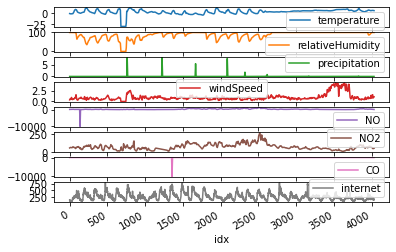

In [35]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5644.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba5644_2.png.png',bbox_inches='tight')
plt.show()

In [36]:
multi_data5644

,temperature,relativeHumidity,precipitation,windSpeed,NO,NO2,CO,internet
idx,,,,,,,,
0.0,-0.200000,99.0,0.0,0.366667,124.500000,57.900000,1.200000,135.029209
1.0,-0.283333,99.0,0.0,0.405556,124.683333,58.866667,1.216667,107.493371
2.0,-0.366667,99.0,0.0,0.444444,124.866667,59.833333,1.233333,116.361533
3.0,-0.450000,99.0,0.0,0.483333,125.050000,60.800000,1.250000,127.892932
4.0,-0.533333,99.0,0.0,0.522222,125.233333,61.766667,1.266667,110.755299
...,...,...,...,...,...,...,...,...
4028.0,6.733333,99.0,0.0,1.100000,88.500000,51.700000,1.500000,170.734492
4029.0,6.700000,99.0,0.0,1.100000,86.500000,51.950000,1.500000,153.487745
4030.0,6.666667,99.0,0.0,1.100000,84.500000,52.200000,1.500000,157.522089


In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(multi_data5644)

In [38]:
dataset = DataScaledMeteoCellId5644

In [39]:
dataset

array([[0.67963387, 1.        , 0.        , ..., 0.18369647, 0.99968011,
        0.07193076],
       [0.67772693, 1.        , 0.        , ..., 0.18732782, 0.99968177,
        0.03321209],
       [0.67581998, 1.        , 0.        , ..., 0.19095918, 0.99968344,
        0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , ..., 0.162284  , 0.9997101 ,
        0.10355843],
       [0.83600305, 1.        , 0.        , ..., 0.16322314, 0.9997101 ,
        0.10700791],
       [0.83524027, 1.        , 0.        , ..., 0.16416228, 0.9997101 ,
        0.08518961]])

In [40]:
len(dataset)

4033

In [41]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [42]:
dataset[:, 7]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [43]:
dataset #dataset[:, [0,1,2,3]]

array([[0.67963387, 1.        , 0.        , ..., 0.18369647, 0.99968011,
        0.07193076],
       [0.67772693, 1.        , 0.        , ..., 0.18732782, 0.99968177,
        0.03321209],
       [0.67581998, 1.        , 0.        , ..., 0.19095918, 0.99968344,
        0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , ..., 0.162284  , 0.9997101 ,
        0.10355843],
       [0.83600305, 1.        , 0.        , ..., 0.16322314, 0.9997101 ,
        0.10700791],
       [0.83524027, 1.        , 0.        , ..., 0.16416228, 0.9997101 ,
        0.08518961]])

In [44]:
#univariate_past_history = 6
#univariate_future_target = 1
past_history = 6
future_target = 1
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 7], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 7],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [45]:
len(x_train_multi)

2817

In [46]:
len(x_val_multi)

1203

In [47]:
EPOCHS = [10, 25, 50, 75, 100]
BATCH_SIZE = [64, 128, 256]
NODOS = [16, 32, 64]
LAYERS = [1, 2, 4, 8]
LEARNINGRATE = [0.002, 0.001, 0.0005]

i = 1
model5644Array = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[2])
                simple_lstm = tf.keras.models.Sequential()
                simple_lstm.add(tf.keras.layers.GRU(nodo, input_shape=x_train_multi.shape[-2:], return_sequences=True))
                for x in range (layer-1):
                    simple_lstm.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_multi, y_train_multi, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_multi, y_val_multi), verbose=0)

                model5644Array.append ([epoch, batch, nodo, layer, LEARNINGRATE[2], simple_lstm, history_lstm])
                if (i % 10 == 0):
                    test = telegram_bot_sendtext(str(i) + ". VM Antigua creado: " + msg)
                i = i + 1

epochs: 10batch: 64nodos: 16layer: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 6, 16)             1248      
_________________________________________________________________
dense (Dense)                (None, 6, 1)              17        
Total params: 1,265
Trainable params: 1,265
Non-trainable params: 0
_________________________________________________________________
epochs: 10batch: 64nodos: 16layer: 2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 6, 16)             1248      
_________________________________________________________________
gru_2 (GRU)                  (None, 6, 16)             1632      
_________________________________________________________________
dense_1 (Dense)         

In [48]:
len(model5644Array)

180

In [49]:
model5644ArrayAcc = []
for model in model5644Array:
    score = model[5].evaluate(x_val_multi, y_val_multi, verbose=0)
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]) + "layer: " + str(model[3]) + "learning rate: " + str(model[4]))
    print('Keras Model Loss = ',score[0])
    print('Keras Model Accuracy = ',score[1])
    model5644ArrayAcc.append ([model[0], model[1], model[2], model[3], model[4], score[0], score[1]])

epochs: 10batch: 64nodos: 16layer: 1learning rate: 0.0005
Keras Model Loss =  0.010952749289572239
Keras Model Accuracy =  0.08024641126394272
epochs: 10batch: 64nodos: 16layer: 2learning rate: 0.0005
Keras Model Loss =  0.011746528558433056
Keras Model Accuracy =  0.08172742277383804
epochs: 10batch: 64nodos: 16layer: 4learning rate: 0.0005
Keras Model Loss =  0.008546720258891582
Keras Model Accuracy =  0.06854775547981262
epochs: 10batch: 64nodos: 16layer: 8learning rate: 0.0005
Keras Model Loss =  0.007777674589306116
Keras Model Accuracy =  0.06371685117483139
epochs: 10batch: 64nodos: 32layer: 1learning rate: 0.0005
Keras Model Loss =  0.010109803639352322
Keras Model Accuracy =  0.07610777020454407
epochs: 10batch: 64nodos: 32layer: 2learning rate: 0.0005
Keras Model Loss =  0.007782508619129658
Keras Model Accuracy =  0.06445307284593582
epochs: 10batch: 64nodos: 32layer: 4learning rate: 0.0005
Keras Model Loss =  0.007698020897805691
Keras Model Accuracy =  0.06330423057079315

In [50]:
model5644ArrayAcc

[[10, 64, 16, 1, 0.0005, 0.010952749289572239, 0.08024641126394272],
 [10, 64, 16, 2, 0.0005, 0.011746528558433056, 0.08172742277383804],
 [10, 64, 16, 4, 0.0005, 0.008546720258891582, 0.06854775547981262],
 [10, 64, 16, 8, 0.0005, 0.007777674589306116, 0.06371685117483139],
 [10, 64, 32, 1, 0.0005, 0.010109803639352322, 0.07610777020454407],
 [10, 64, 32, 2, 0.0005, 0.007782508619129658, 0.06445307284593582],
 [10, 64, 32, 4, 0.0005, 0.007698020897805691, 0.06330423057079315],
 [10, 64, 32, 8, 0.0005, 0.0066535258665680885, 0.057662997394800186],
 [10, 64, 64, 1, 0.0005, 0.009072927758097649, 0.07008552551269531],
 [10, 64, 64, 2, 0.0005, 0.0063030533492565155, 0.05605825409293175],
 [10, 64, 64, 4, 0.0005, 0.005538034252822399, 0.05046222731471062],
 [10, 64, 64, 8, 0.0005, 0.005346979014575481, 0.04858221858739853],
 [10, 128, 16, 1, 0.0005, 0.02166709676384926, 0.12144485116004944],
 [10, 128, 16, 2, 0.0005, 0.020919058471918106, 0.1187126561999321],
 [10, 128, 16, 4, 0.0005, 0.032

In [51]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])
fileGruMulti = 'transformed_data/model5644multi-6-0-1-TRPWNN2C-acc_GRU_3.csv'
dfModel5644ArrayAcc.to_csv(fileGruMulti, encoding='utf-8')

In [52]:
telegram_bot_sendtext("VM Antigua creado acc: ")
telegram_bot_sendtext(fileGruMulti)

{'ok': False,
 'error_code': 400,
 'description': "Bad Request: can't parse entities: Can't find end of the entity starting at byte offset 54"}

In [53]:
model5644mse = []
for model in model5644Array:
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]) + "layer: " + str(model[3]) + "learning rate: " + str(model[4]))
    test_predictions = model[5].predict(x_val_multi)
    mse = tf.keras.losses.MeanSquaredError()
    dmse = mse(y_val_multi, test_predictions).numpy()
    #RMSE
    rmse = tf.keras.metrics.RootMeanSquaredError()
    drmse = rmse(y_val_multi, test_predictions).numpy()
    model5644mse.append ([model[0], model[1], model[2], model[3], model[4], dmse, drmse])

epochs: 10batch: 64nodos: 16layer: 1learning rate: 0.0005
epochs: 10batch: 64nodos: 16layer: 2learning rate: 0.0005
epochs: 10batch: 64nodos: 16layer: 4learning rate: 0.0005
epochs: 10batch: 64nodos: 16layer: 8learning rate: 0.0005
epochs: 10batch: 64nodos: 32layer: 1learning rate: 0.0005
epochs: 10batch: 64nodos: 32layer: 2learning rate: 0.0005
epochs: 10batch: 64nodos: 32layer: 4learning rate: 0.0005
epochs: 10batch: 64nodos: 32layer: 8learning rate: 0.0005
epochs: 10batch: 64nodos: 64layer: 1learning rate: 0.0005
epochs: 10batch: 64nodos: 64layer: 2learning rate: 0.0005
epochs: 10batch: 64nodos: 64layer: 4learning rate: 0.0005
epochs: 10batch: 64nodos: 64layer: 8learning rate: 0.0005
epochs: 10batch: 128nodos: 16layer: 1learning rate: 0.0005
epochs: 10batch: 128nodos: 16layer: 2learning rate: 0.0005
epochs: 10batch: 128nodos: 16layer: 4learning rate: 0.0005
epochs: 10batch: 128nodos: 16layer: 8learning rate: 0.0005
epochs: 10batch: 128nodos: 32layer: 1learning rate: 0.0005
epochs: 1

In [54]:
len(model5644mse)

180

In [55]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])
fileGruMulti2 = 'transformed_data/model5644multi-6-0-1-TRPWNN2C-mse_GRU_3.csv'
dfModel5644mse.to_csv(fileGruMulti2, encoding='utf-8')

In [56]:
test = telegram_bot_sendtext("VM Antigua creado mse: ")
telegram_bot_sendtext(fileGruMulti2)

{'ok': False,
 'error_code': 400,
 'description': "Bad Request: can't parse entities: Can't find end of the entity starting at byte offset 54"}

# Prueba mejor caso 5644 univariable

In [ ]:
EPOCHS = [10]
BATCH_SIZE = [256]
NODOS = [16]
LAYERS = [8]
LEARNINGRATE = [0.0005]

model5644Array = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                print ("epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer))
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_lstm = tf.keras.models.Sequential()
                simple_lstm.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                for x in range (layer-1):
                    simple_lstm.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                simple_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm.summary()

                simple_lstm.compile(optimizer=adam, loss=tf.losses.mae, metrics=[tf.metrics.MeanAbsoluteError(), 'accuracy'])

                history_lstm = simple_lstm.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)

                model5644Array.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], simple_lstm, history_lstm])

In [ ]:
len(model5644Array)

In [ ]:
model5644ArrayAcc = []
for model in model5644Array:
    score = model[5].evaluate(x_train_uni, y_train_uni, verbose=0)
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]) + "layer: " + str(model[3]) + "learning rate: " + str(model[4]))
    print('Keras Model Loss = ',score[0])
    print('Keras Model Accuracy = ',score[1])
    model5644ArrayAcc.append ([model[0], model[1], model[2], model[3], model[4], score[0], score[1]])

In [ ]:
model5644ArrayAcc

In [ ]:
dfModel5644ArrayAcc = pd.DataFrame(data = model5644ArrayAcc, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc'])

In [ ]:
#test_predictions_5459_batch_32 = simple_lstm_model_5459_batch_32.predict(x_val_uni_cellId[0])

#mse_5459_batch_32 = tf.keras.losses.MeanSquaredError()
#mse_5459_batch_32(y_val_uni_cellId[0], test_predictions_5459_batch_32).numpy()

In [ ]:
#RMSE
#mse_5459_batch_32 = tf.keras.metrics.RootMeanSquaredError()
#mse_5459_batch_32(y_val_uni_cellId[0], test_predictions_5459_batch_32).numpy()

In [ ]:
model5644mse = []
for model in model5644Array:
    print ("epochs: " + str(model[0]) + "batch: " + str(model[1]) + "nodos: " + str(model[2]) + "layer: " + str(model[3]) + "learning rate: " + str(model[4]))
    test_predictions = model[5].predict(x_val_uni)
    mse = tf.keras.losses.MeanSquaredError()
    dmse = mse(y_val_uni, test_predictions).numpy()
    print (dmse)
    #RMSE
    rmse = tf.keras.metrics.RootMeanSquaredError()
    drmse = rmse(y_val_uni, test_predictions).numpy()
    print (drmse)

In [ ]:
len(model5644mse)

In [ ]:
for i in range (0,19):
    plot = show_plot([x_val_uni[i*5], y_val_uni[i*5],
                    simple_lstm_model_5459.predict(x_val_uni)[i*5]], 0, 'Simple LSTM model CellId 5644')
    plot.show()

In [ ]:
dfModel5644mse = pd.DataFrame(data = model5644mse, columns = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse'])

In [ ]:
model5644mse.to_csv('transformed_data/model5644_1.csv', encoding='utf-8')

In [ ]:
for i in range (0,19):
    plot = show_plot([x_val_uni_cellId[1][i*5], y_val_uni_cellId[1][i*5],
                    simple_lstm_model_5644.predict(x_val_uni_cellId[1])[i*5]], 0, 'Simple LSTM model CellId 5644')
    plot.show()

In [ ]:
test_predictions_5644 = simple_lstm_model_5644.predict(x_val_uni_cellId[1]).flatten()

plt.figure(figsize=(16, 12), dpi=100) 
a = plt.axes(aspect='equal')
plt.scatter(y_val_uni_cellId[1], test_predictions_5644)
plt.title('Prediction accuracy CellId 5644')
plt.xlabel('True Values [Internet]')
plt.ylabel('Predictions [Internet]')
xlims = [-2, 2]
ylims = [-2, 2]
plt.xlim(xlims)
plt.ylim(ylims)
_ = plt.plot(xlims, ylims)

In [ ]:
error = test_predictions_5644 - y_val_uni_cellId[1]
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error [Internet]")
_ = plt.ylabel("Count")

In [ ]:
features_considered = ['temperature', 'internet', 'relativeHumidity', 'hour']

In [ ]:
features_considered = ['callin', 'internet', 'callout', 'smsin', 'smsout']

In [ ]:
features = dataMeteoCellId[features_considered]
features.index = dataMeteoCellId['hour'] + dataMeteoCellId['weekday'] * 24 + (dataMeteoCellId['week'] - 48) * 24 * 7
features.head()

In [ ]:
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [ ]:
dataset = (dataset-data_mean)/data_std

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
past_history = 48
future_target = 6
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [ ]:
y_train_single

In [ ]:
x_train_single

In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae', metrics=['mae', 'mse'])

In [ ]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

In [ ]:
single_step_history = single_step_model.fit(train_data_single, epochs=50,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

In [ ]:
def plot_train_history_mse(history, title):
    mse = history.history['mse']
    val_mse = history.history['val_mse']

    epochs = range(len(mse))

    plt.figure()

    plt.plot(epochs, mse, 'b', label='Training loss')
    plt.plot(epochs, val_mse, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('MSE')

    plt.show()

In [ ]:
plot_train_history_mse(single_step_history,
                   'Single Step Training and validation loss')

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Predict a single step future

In [ ]:
for x, y in val_data_single.take(12):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

# Multi-Step model

In [ ]:
future_target = 6
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target Internet CDR to predict : {}'.format(y_train_multi[0].shape))

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(6))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae', metrics=['mae', 'mse'])

In [ ]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim = 5, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1,activation='linear'))

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy','mae', 'mse'])

In [ ]:
model.summary()

In [ ]:
history1024 = model.fit(normed_X_train, y_train, epochs=1000, validation_split = 0.2, batch_size=1024, validation_data=(normed_X_test, y_test), verbose = 0, callbacks=[tfdocs.modeling.EpochDots()])

In [ ]:
hist = pd.DataFrame(history1024.history)
hist['epoch'] = history1024.epoch
hist.tail()

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [ ]:
plotter.plot({'Basic': history1024}, metric = "mae")
plt.ylabel('MAE [Internet]')

In [ ]:
plotter.plot({'Basic': history1024}, metric = "mse")
plt.ylabel('MSE [Internet^2]')

In [ ]:
test_predictions = model.predict(normed_X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [Internet]')
plt.ylabel('Predictions [Internet]')
lims = [0, 8000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Internet]")
_ = plt.ylabel("Count")

# Comparacion de datos

## Datos LSTM Model 5644

In [57]:
singleModel5644Acc = pd.DataFrame({})
singleModel5644Mse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAcc = pd.read_csv('transformed_data/model5644-6-0-1-acc_LSTM_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMse = pd.read_csv('transformed_data/model5644-6-0-1-mse_LSTM_'+str(index).zfill(1) +'.csv')
    singleModel5644Acc = singleModel5644Acc.append(singleModel5644OneAcc)
    singleModel5644Mse = singleModel5644Mse.append(singleModel5644OneMse)

singleModel5644Mse.head()

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,mse,rmse
0,0,10,64,16,1,0.002,0.020020,0.141492
1,1,10,64,16,2,0.002,0.019654,0.140193
2,2,10,64,16,4,0.002,0.019556,0.139842
3,3,10,64,16,8,0.002,0.019458,0.139493
4,4,10,64,32,1,0.002,0.020038,0.141556


In [58]:
singleModel5644Acc

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,keras_loss_model,keras_model_acc
0,0,10,64,16,1,0.0020,0.010112,0.073187
1,1,10,64,16,2,0.0020,0.008530,0.065795
2,2,10,64,16,4,0.0020,0.007697,0.063137
3,3,10,64,16,8,0.0020,0.010895,0.075306
4,4,10,64,32,1,0.0020,0.009067,0.068430
...,...,...,...,...,...,...,...,...
175,175,100,256,32,8,0.0005,0.011083,0.075551
176,176,100,256,64,1,0.0005,0.010688,0.075191
177,177,100,256,64,2,0.0005,0.008101,0.064351
178,178,100,256,64,4,0.0005,0.007336,0.061506


In [59]:
singleModel5644Mse.columns.values.tolist()

['Unnamed: 0',
 'epochs',
 'batch',
 'nodos',
 'layer',
 'learning rate',
 'mse',
 'rmse']

In [60]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644Acc = singleModel5644Acc[features_acc]

In [61]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644Mse = singleModel5644Mse[features_mse]

In [62]:
singleModel5644Mse.to_csv('transformed_data/memory_data/model5644-6-0-1-mse_lstm.csv', encoding='utf-8')

In [63]:
idxMse = pd.MultiIndex.from_frame (singleModel5644Mse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644Acc)

In [64]:
idxMse

MultiIndex([( 10,  64, 16, 1,  0.002,  0.02001989632844925, ...),
            ( 10,  64, 16, 2,  0.002,  0.01965412311255932, ...),
            ( 10,  64, 16, 4,  0.002,  0.01955572515726089, ...),
            ( 10,  64, 16, 8,  0.002,  0.01945832371711731, ...),
            ( 10,  64, 32, 1,  0.002,  0.02003803849220276, ...),
            ( 10,  64, 32, 2,  0.002,  0.01968755200505257, ...),
            ( 10,  64, 32, 4,  0.002, 0.019995031878352162, ...),
            ( 10,  64, 32, 8,  0.002,  0.02228044718503952, ...),
            ( 10,  64, 64, 1,  0.002,  0.01958796568214893, ...),
            ( 10,  64, 64, 2,  0.002,  0.01990463025867939, ...),
            ...
            (100, 256, 16, 4, 0.0005,   0.0202515609562397, ...),
            (100, 256, 16, 8, 0.0005,  0.01894407346844673, ...),
            (100, 256, 32, 1, 0.0005, 0.021054306998848915, ...),
            (100, 256, 32, 2, 0.0005, 0.020067216828465458, ...),
            (100, 256, 32, 4, 0.0005,  0.01993673481047153, 

In [65]:
idxMse.min()

(10, 64, 16, 1, 0.0005, 0.029949506744742393, 0.17305926978588104)

In [77]:
tabla1 = singleModel5644Mse[singleModel5644Mse['mse'] < 0.0189]

In [78]:
tabla1.to_excel("model5644mse-6-0-1_lstm_min.xlsx")

In [79]:
idxMse.max()

(100, 256, 64, 8, 0.002, 0.0182767566293478, 0.13519155979156494)

In [80]:
tabla2 = singleModel5644Mse[singleModel5644Mse['mse'] > 0.042]

In [81]:
tabla2.to_excel("model5644mse-6-0-1_lstm_max.xlsx")

In [82]:
singleModel5644Mse['mse'].mean()

0.022017049285824652

## Datos LSTM Model 5644 - GRU

In [83]:
singleModel5644AccGRU = pd.DataFrame({})
singleModel5644MseGRU = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAccGRU = pd.read_csv('transformed_data/model5644-6-0-1-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMseGRU = pd.read_csv('transformed_data/model5644-6-0-1-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644AccGRU = singleModel5644AccGRU.append(singleModel5644OneAccGRU)
    singleModel5644MseGRU = singleModel5644MseGRU.append(singleModel5644OneMseGRU)

singleModel5644MseGRU.head()

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,mse,rmse
0,0,10,64,16,1,0.002,0.018897,0.137467
1,1,10,64,16,2,0.002,0.019382,0.139220
2,2,10,64,16,4,0.002,0.020313,0.142523
3,3,10,64,16,8,0.002,0.020982,0.144853
4,4,10,64,32,1,0.002,0.019162,0.138426


In [84]:
singleModel5644AccGRU

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,keras_loss_model,keras_model_acc
0,0,10,64,16,1,0.0020,0.008319,0.066430
1,1,10,64,16,2,0.0020,0.007562,0.061841
2,2,10,64,16,4,0.0020,0.007294,0.061383
3,3,10,64,16,8,0.0020,0.007315,0.061003
4,4,10,64,32,1,0.0020,0.008059,0.064467
...,...,...,...,...,...,...,...,...
175,175,100,256,32,8,0.0005,0.007413,0.059885
176,176,100,256,64,1,0.0005,0.009096,0.068374
177,177,100,256,64,2,0.0005,0.007521,0.062465
178,178,100,256,64,4,0.0005,0.007298,0.060061


In [85]:
singleModel5644AccGRU.columns.values.tolist()

['Unnamed: 0',
 'epochs',
 'batch',
 'nodos',
 'layer',
 'learning rate',
 'keras_loss_model',
 'keras_model_acc']

In [86]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644AccGRU = singleModel5644AccGRU[features_acc]

In [87]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644MseGRU = singleModel5644MseGRU[features_mse]

In [88]:
singleModel5644MseGRU.to_csv('transformed_data/memory_data/model5644-6-0-1-mse_gru.csv', encoding='utf-8')

In [89]:
idxMseGRU = pd.MultiIndex.from_frame (singleModel5644MseGRU)
idxAccGRU = pd.MultiIndex.from_frame (singleModel5644AccGRU)

In [90]:
idxMseGRU

MultiIndex([( 10,  64, 16, 1,  0.002, 0.018897190690040592, ...),
            ( 10,  64, 16, 2,  0.002, 0.019382240250706676, ...),
            ( 10,  64, 16, 4,  0.002, 0.020312832668423653, ...),
            ( 10,  64, 16, 8,  0.002, 0.020982403308153152, ...),
            ( 10,  64, 32, 1,  0.002, 0.019161643460392952, ...),
            ( 10,  64, 32, 2,  0.002,  0.02002392895519733, ...),
            ( 10,  64, 32, 4,  0.002, 0.020341627299785614, ...),
            ( 10,  64, 32, 8,  0.002, 0.021352948620915413, ...),
            ( 10,  64, 64, 1,  0.002,  0.01942292042076588, ...),
            ( 10,  64, 64, 2,  0.002,  0.02014182321727276, ...),
            ...
            (100, 256, 16, 4, 0.0005,  0.01986178010702133, ...),
            (100, 256, 16, 8, 0.0005, 0.020078880712389943, ...),
            (100, 256, 32, 1, 0.0005,  0.01880405656993389, ...),
            (100, 256, 32, 2, 0.0005,  0.01867583580315113, ...),
            (100, 256, 32, 4, 0.0005,  0.02024480514228344, 

In [91]:
idxMseGRU.min()

(10, 64, 16, 1, 0.0005, 0.0234750397503376, 0.1532156765460968)

In [110]:
tabla1 = singleModel5644MseGRU[singleModel5644MseGRU['mse'] < 0.018575]

In [111]:
tabla1.to_excel("model5644mse-6-0-1_gru_min.xlsx")

In [99]:
idxMseGRU.max()

(100, 256, 64, 8, 0.002, 0.018029429018497467, 0.1342737078666687)

In [115]:
tabla2 = singleModel5644MseGRU[singleModel5644MseGRU['mse'] > 0.028]

In [113]:
tabla2.to_excel("model5644mse-6-0-1_gru_max.xlsx")

In [116]:
singleModel5644MseGRU['mse'].mean()

0.020433706393534385

## Datos LSTM TRPW Model 5644 (no separarados)

In [117]:
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPWNN2C-acc_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPWNN2C-mse_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,mse,rmse
0,0,10,64,16,1,0.002,0.019832,0.140826
1,1,10,64,16,2,0.002,0.019857,0.140913
2,2,10,64,16,4,0.002,0.020753,0.144060
3,3,10,64,16,8,0.002,0.024607,0.156867
4,4,10,64,32,1,0.002,0.019945,0.141228


In [118]:
singleModel5644TRPWAcc

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,keras_loss_model,keras_model_acc
0,0,10,64,16,1,0.0020,0.008558,0.067590
1,1,10,64,16,2,0.0020,0.008031,0.064719
2,2,10,64,16,4,0.0020,0.008150,0.063892
3,3,10,64,16,8,0.0020,0.007972,0.065538
4,4,10,64,32,1,0.0020,0.008008,0.065085
...,...,...,...,...,...,...,...,...
175,175,100,256,32,8,0.0005,0.010488,0.074541
176,176,100,256,64,1,0.0005,0.009360,0.069518
177,177,100,256,64,2,0.0005,0.007458,0.062004
178,178,100,256,64,4,0.0005,0.006807,0.058733


In [119]:
singleModel5644TRPWMse.columns.values.tolist()

['Unnamed: 0',
 'epochs',
 'batch',
 'nodos',
 'layer',
 'learning rate',
 'mse',
 'rmse']

In [120]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

,epochs,batch,nodos,layer,learning rate,keras_loss_model,keras_model_acc
0,10,64,16,1,0.0020,0.008558,0.067590
1,10,64,16,2,0.0020,0.008031,0.064719
2,10,64,16,4,0.0020,0.008150,0.063892
3,10,64,16,8,0.0020,0.007972,0.065538
4,10,64,32,1,0.0020,0.008008,0.065085
...,...,...,...,...,...,...,...
175,100,256,32,8,0.0005,0.010488,0.074541
176,100,256,64,1,0.0005,0.009360,0.069518
177,100,256,64,2,0.0005,0.007458,0.062004
178,100,256,64,4,0.0005,0.006807,0.058733


In [121]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

,epochs,batch,nodos,layer,learning rate,mse,rmse
0,10,64,16,1,0.0020,0.019832,0.140826
1,10,64,16,2,0.0020,0.019857,0.140913
2,10,64,16,4,0.0020,0.020753,0.144060
3,10,64,16,8,0.0020,0.024607,0.156867
4,10,64,32,1,0.0020,0.019945,0.141228
...,...,...,...,...,...,...,...
175,100,256,32,8,0.0005,0.020802,0.144229
176,100,256,64,1,0.0005,0.019159,0.138416
177,100,256,64,2,0.0005,0.020272,0.142380
178,100,256,64,4,0.0005,0.022264,0.149212


In [122]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-6-0-1-TRPWNN2C-mse_lstm.csv', encoding='utf-8')

In [123]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [124]:
idxMse

MultiIndex([(  0,  10,  64, 16, 1,  0.002,  0.01983199268579483, ...),
            (  1,  10,  64, 16, 2,  0.002,   0.0198565162718296, ...),
            (  2,  10,  64, 16, 4,  0.002,  0.02075328677892685, ...),
            (  3,  10,  64, 16, 8,  0.002, 0.024607129395008087, ...),
            (  4,  10,  64, 32, 1,  0.002,  0.01994526945054531, ...),
            (  5,  10,  64, 32, 2,  0.002, 0.020535599440336227, ...),
            (  6,  10,  64, 32, 4,  0.002, 0.021441666409373283, ...),
            (  7,  10,  64, 32, 8,  0.002, 0.024049656465649605, ...),
            (  8,  10,  64, 64, 1,  0.002,  0.01989114098250866, ...),
            (  9,  10,  64, 64, 2,  0.002,   0.0207122266292572, ...),
            ...
            (170, 100, 256, 16, 4, 0.0005,  0.02133064903318882, ...),
            (171, 100, 256, 16, 8, 0.0005,  0.02139878086745739, ...),
            (172, 100, 256, 32, 1, 0.0005,  0.02036017365753651, ...),
            (173, 100, 256, 32, 2, 0.0005, 0.0197966489940881

In [125]:
idxMse.min()

(0, 10, 64, 16, 1, 0.0005, 0.021439887583255768, 0.14642365276813507)

In [140]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.01945]

In [141]:
tabla1.to_excel("model5644multi-6-0-1-TRPWNN2C-mse_lstm_min.xlsx")

In [142]:
idxMse.max()

(179, 100, 256, 64, 8, 0.002, 0.022649886086583138, 0.15049877762794495)

In [143]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.038]

In [144]:
tabla2.to_excel("model5644multi-6-0-1-TRPWNN2C-mse_lstm_max.xlsx")

In [145]:
singleModel5644TRPWMse['mse'].mean()

0.02334718722850084

## Datos LSTM TRPW Model 5644 (separarados)

In [170]:
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPWNN2C-sep-acc_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPWNN2C-sep-mse_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,mse,rmse
0,0,10,64,16,1,0.002,0.030333,0.174163
1,1,10,64,16,2,0.002,0.030411,0.174388
2,2,10,64,16,4,0.002,0.020343,0.142630
3,3,10,64,16,8,0.002,0.020603,0.143536
4,4,10,64,32,1,0.002,0.044999,0.212129


In [171]:
singleModel5644TRPWAcc

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,keras_loss_model,keras_model_acc
0,0,10,64,16,1,0.0020,0.032739,0.142727
1,1,10,64,16,2,0.0020,0.032619,0.142462
2,2,10,64,16,4,0.0020,0.034783,0.148377
3,3,10,64,16,8,0.0020,0.034825,0.148682
4,4,10,64,32,1,0.0020,0.031852,0.140779
...,...,...,...,...,...,...,...,...
175,175,100,256,32,8,0.0005,0.032726,0.144003
176,176,100,256,64,1,0.0005,0.032035,0.142474
177,177,100,256,64,2,0.0005,0.031878,0.142496
178,178,100,256,64,4,0.0005,0.031493,0.141867


In [172]:
singleModel5644TRPWMse.columns.values.tolist()

['Unnamed: 0',
 'epochs',
 'batch',
 'nodos',
 'layer',
 'learning rate',
 'mse',
 'rmse']

In [173]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

,epochs,batch,nodos,layer,learning rate,keras_loss_model,keras_model_acc
0,10,64,16,1,0.0020,0.032739,0.142727
1,10,64,16,2,0.0020,0.032619,0.142462
2,10,64,16,4,0.0020,0.034783,0.148377
3,10,64,16,8,0.0020,0.034825,0.148682
4,10,64,32,1,0.0020,0.031852,0.140779
...,...,...,...,...,...,...,...
175,100,256,32,8,0.0005,0.032726,0.144003
176,100,256,64,1,0.0005,0.032035,0.142474
177,100,256,64,2,0.0005,0.031878,0.142496
178,100,256,64,4,0.0005,0.031493,0.141867


In [174]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

,epochs,batch,nodos,layer,learning rate,mse,rmse
0,10,64,16,1,0.0020,0.030333,0.174163
1,10,64,16,2,0.0020,0.030411,0.174388
2,10,64,16,4,0.0020,0.020343,0.142630
3,10,64,16,8,0.0020,0.020603,0.143536
4,10,64,32,1,0.0020,0.044999,0.212129
...,...,...,...,...,...,...,...
175,100,256,32,8,0.0005,0.028626,0.169193
176,100,256,64,1,0.0005,0.051672,0.227315
177,100,256,64,2,0.0005,0.050871,0.225545
178,100,256,64,4,0.0005,0.072115,0.268541


In [175]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-6-0-1-TRPWNN2C-sep-mse_lstm.csv', encoding='utf-8')

In [176]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [177]:
idxMse

MultiIndex([(  0,  10,  64, 16, 1,  0.002, 0.030332766473293308, ...),
            (  1,  10,  64, 16, 2,  0.002, 0.030411090701818463, ...),
            (  2,  10,  64, 16, 4,  0.002,  0.02034333162009716, ...),
            (  3,  10,  64, 16, 8,  0.002, 0.020602721720933914, ...),
            (  4,  10,  64, 32, 1,  0.002, 0.044998791068792336, ...),
            (  5,  10,  64, 32, 2,  0.002, 0.044696103781461716, ...),
            (  6,  10,  64, 32, 4,  0.002,  0.02011275850236416, ...),
            (  7,  10,  64, 32, 8,  0.002,  0.02613227441906929, ...),
            (  8,  10,  64, 64, 1,  0.002,  0.04375247284770012, ...),
            (  9,  10,  64, 64, 2,  0.002, 0.050663962960243225, ...),
            ...
            (170, 100, 256, 16, 4, 0.0005, 0.020777983590960503, ...),
            (171, 100, 256, 16, 8, 0.0005, 0.028428263962268833, ...),
            (172, 100, 256, 32, 1, 0.0005,  0.04062199592590332, ...),
            (173, 100, 256, 32, 2, 0.0005, 0.0368724912405014

In [178]:
idxMse.min()

(0, 10, 64, 16, 1, 0.0005, 0.0237310379743576, 0.15404881536960602)

In [189]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.0185]

In [190]:
tabla1.to_excel("model5644multi-6-0-1-TRPWNN2C-sep-mse_lstm_min.xlsx")

In [191]:
idxMse.max()

(179, 100, 256, 64, 8, 0.002, 0.038958027958869934, 0.19737787544727325)

In [192]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.109]

In [193]:
tabla2.to_excel("model5644multi-6-0-1-TRPWNN2C-sep-mse_lstm_max.xlsx")

In [194]:
singleModel5644TRPWMse['mse'].mean()

0.045959766495420974

## Datos GRU TRPW Model 5644 (no separarados)

In [146]:
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPWNN2C-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPWNN2C-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,mse,rmse
0,0,10,64,16,1,0.002,0.018881,0.137408
1,1,10,64,16,2,0.002,0.020567,0.143412
2,2,10,64,16,4,0.002,0.019838,0.140847
3,3,10,64,16,8,0.002,0.022747,0.150821
4,4,10,64,32,1,0.002,0.020011,0.141459


In [147]:
singleModel5644TRPWMse

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,mse,rmse
0,0,10,64,16,1,0.0020,0.018881,0.137408
1,1,10,64,16,2,0.0020,0.020567,0.143412
2,2,10,64,16,4,0.0020,0.019838,0.140847
3,3,10,64,16,8,0.0020,0.022747,0.150821
4,4,10,64,32,1,0.0020,0.020011,0.141459
...,...,...,...,...,...,...,...,...
175,175,100,256,32,8,0.0005,0.022140,0.148795
176,176,100,256,64,1,0.0005,0.019438,0.139421
177,177,100,256,64,2,0.0005,0.020394,0.142807
178,178,100,256,64,4,0.0005,0.022830,0.151097


In [148]:
singleModel5644TRPWAcc

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,keras_loss_model,keras_model_acc
0,0,10,64,16,1,0.0020,0.006134,0.054991
1,1,10,64,16,2,0.0020,0.006277,0.056206
2,2,10,64,16,4,0.0020,0.005597,0.049922
3,3,10,64,16,8,0.0020,0.006303,0.056114
4,4,10,64,32,1,0.0020,0.006260,0.055917
...,...,...,...,...,...,...,...,...
175,175,100,256,32,8,0.0005,0.006518,0.056845
176,176,100,256,64,1,0.0005,0.006516,0.056936
177,177,100,256,64,2,0.0005,0.006072,0.054292
178,178,100,256,64,4,0.0005,0.007399,0.063178


In [149]:
singleModel5644TRPWMse.columns.values.tolist()

['Unnamed: 0',
 'epochs',
 'batch',
 'nodos',
 'layer',
 'learning rate',
 'mse',
 'rmse']

In [150]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [151]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [152]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-6-0-1-TRPWNN2C-mse_gru.csv', encoding='utf-8')

In [153]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [154]:
idxMse

MultiIndex([( 10,  64, 16, 1,  0.002, 0.018880845978856087, ...),
            ( 10,  64, 16, 2,  0.002, 0.020567093044519424, ...),
            ( 10,  64, 16, 4,  0.002,  0.01983796060085297, ...),
            ( 10,  64, 16, 8,  0.002, 0.022746885195374492, ...),
            ( 10,  64, 32, 1,  0.002,  0.02001052908599377, ...),
            ( 10,  64, 32, 2,  0.002,  0.02066631056368351, ...),
            ( 10,  64, 32, 4,  0.002, 0.021114245057106015, ...),
            ( 10,  64, 32, 8,  0.002, 0.023170679807662964, ...),
            ( 10,  64, 64, 1,  0.002,  0.01989142596721649, ...),
            ( 10,  64, 64, 2,  0.002,  0.02103528380393982, ...),
            ...
            (100, 256, 16, 4, 0.0005, 0.020005898550152782, ...),
            (100, 256, 16, 8, 0.0005, 0.022124221548438072, ...),
            (100, 256, 32, 1, 0.0005,  0.01998064108192921, ...),
            (100, 256, 32, 2, 0.0005, 0.019614752382040024, ...),
            (100, 256, 32, 4, 0.0005, 0.021138979122042656, 

In [155]:
idxMse.min()

(10, 64, 16, 1, 0.0005, 0.02034015394747257, 0.14261889457702634)

In [164]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.0181]

In [165]:
tabla1.to_excel("model5644multi-6-0-1-TRPWNN2C-mse_gru_min.xlsx")

In [166]:
idxMse.max()

(100, 256, 64, 8, 0.002, 0.022284414619207386, 0.1492796391248703)

In [167]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.02885]

In [168]:
tabla2.to_excel("model5644multi-6-0-1-TRPWNN2C-mse_gru_max.xlsx")

In [169]:
singleModel5644TRPWMse['mse'].mean()

0.022035162275036175

## Datos GRU TRPW Model 5644 (separarados)

In [195]:
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPWNN2C-sep-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-6-0-1-TRPWNN2C-sep-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,mse,rmse
0,0,10,64,16,1,0.002,0.037310,0.193159
1,1,10,64,16,2,0.002,0.047858,0.218764
2,2,10,64,16,4,0.002,0.051843,0.227691
3,3,10,64,16,8,0.002,0.036035,0.189828
4,4,10,64,32,1,0.002,0.052885,0.229968


In [196]:
singleModel5644TRPWAcc

,Unnamed: 0,epochs,batch,nodos,layer,learning rate,keras_loss_model,keras_model_acc
0,0,10,64,16,1,0.0020,0.039084,0.157035
1,1,10,64,16,2,0.0020,0.050213,0.173469
2,2,10,64,16,4,0.0020,0.053937,0.183186
3,3,10,64,16,8,0.0020,0.037238,0.157179
4,4,10,64,32,1,0.0020,0.055512,0.179531
...,...,...,...,...,...,...,...,...
175,175,100,256,32,8,0.0005,0.069780,0.210116
176,176,100,256,64,1,0.0005,0.062126,0.192050
177,177,100,256,64,2,0.0005,0.070692,0.207712
178,178,100,256,64,4,0.0005,0.077813,0.217863


In [197]:
singleModel5644TRPWMse.columns.values.tolist()

['Unnamed: 0',
 'epochs',
 'batch',
 'nodos',
 'layer',
 'learning rate',
 'mse',
 'rmse']

In [198]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [199]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [200]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-6-0-1-TRPWNN2C-sep-mse_gru.csv', encoding='utf-8')

In [201]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [202]:
idxMse

MultiIndex([( 10,  64, 16, 1,  0.002,  0.03731043636798858, ...),
            ( 10,  64, 16, 2,  0.002,  0.04785773903131485, ...),
            ( 10,  64, 16, 4,  0.002, 0.051843009889125824, ...),
            ( 10,  64, 16, 8,  0.002,  0.03603456541895866, ...),
            ( 10,  64, 32, 1,  0.002,  0.05288543924689293, ...),
            ( 10,  64, 32, 2,  0.002,  0.05556962639093399, ...),
            ( 10,  64, 32, 4,  0.002,  0.04639268293976784, ...),
            ( 10,  64, 32, 8,  0.002,  0.04471741244196892, ...),
            ( 10,  64, 64, 1,  0.002,  0.05268684402108192, ...),
            ( 10,  64, 64, 2,  0.002,  0.05804775655269623, ...),
            ...
            (100, 256, 16, 4, 0.0005, 0.028739744797348976, ...),
            (100, 256, 16, 8, 0.0005,  0.03341075032949448, ...),
            (100, 256, 32, 1, 0.0005,  0.04227181524038315, ...),
            (100, 256, 32, 2, 0.0005, 0.059969659894704826, ...),
            (100, 256, 32, 4, 0.0005,  0.05967166274785996, 

In [203]:
idxMse.min()

(10, 64, 16, 1, 0.0005, 0.021432595327496532, 0.14639876782894135)

In [214]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.0183]

In [215]:
tabla1.to_excel("model5644multi-6-0-1-TRPWNN2C-sep-mse_gru_min.xlsx")

In [216]:
idxMse.max()

(100, 256, 64, 8, 0.002, 0.030440272763371468, 0.1744714081287384)

In [217]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.1059]

In [218]:
tabla2.to_excel("model5644multi-6-0-1-TRPWNN2C-sep-mse_gru_max.xlsx")

In [219]:
singleModel5644TRPWMse['mse'].mean()

0.053797129262238744

# Comparacion de datos 12-0-6

## Datos LSTM Model 5644 12-0-6

In [ ]:
#OK
singleModel5644Acc = pd.DataFrame({})
singleModel5644Mse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAcc = pd.read_csv('transformed_data/model5644acc-12-0-6_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMse = pd.read_csv('transformed_data/model5644mse-12-0-6_'+str(index).zfill(1) +'.csv')
    singleModel5644Acc = singleModel5644Acc.append(singleModel5644OneAcc)
    singleModel5644Mse = singleModel5644Mse.append(singleModel5644OneMse)

singleModel5644Mse.head()

In [ ]:
singleModel5644Acc

In [ ]:
singleModel5644Mse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644Acc = singleModel5644Acc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644Mse = singleModel5644Mse[features_mse]

In [ ]:
singleModel5644Mse.to_csv('transformed_data/memory_data/model5644mse-12-0-6_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644Mse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644Acc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644Mse[singleModel5644Mse['mse'] < 0.0285]

In [ ]:
tabla1.to_excel("model5644mse-12-0-6_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644Mse[singleModel5644Mse['mse'] > 0.03822]

In [ ]:
tabla2.to_excel("model5644mse-12-0-6_lstm_max.xlsx")

In [ ]:
singleModel5644Mse['mse'].mean()

## Datos LSTM Model 5644 - GRU 12-0-6

In [ ]:
#OK
singleModel5644AccGRU = pd.DataFrame({})
singleModel5644MseGRU = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAccGRU = pd.read_csv('transformed_data/model5644acc-12-0-6-GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMseGRU = pd.read_csv('transformed_data/model5644mse-12-0-6-GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644AccGRU = singleModel5644AccGRU.append(singleModel5644OneAccGRU)
    singleModel5644MseGRU = singleModel5644MseGRU.append(singleModel5644OneMseGRU)

singleModel5644MseGRU.head()

In [ ]:
singleModel5644AccGRU

In [ ]:
singleModel5644AccGRU.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644AccGRU = singleModel5644AccGRU[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644MseGRU = singleModel5644MseGRU[features_mse]

In [ ]:
singleModel5644MseGRU.to_csv('transformed_data/memory_data/model5644mse-12-0-6_gru.csv', encoding='utf-8')

In [ ]:
idxMseGRU = pd.MultiIndex.from_frame (singleModel5644MseGRU)
idxAccGRU = pd.MultiIndex.from_frame (singleModel5644AccGRU)

In [ ]:
idxMseGRU

In [ ]:
idxMseGRU.min()

In [ ]:
tabla1 = singleModel5644MseGRU[singleModel5644MseGRU['mse'] < 0.0269]

In [ ]:
tabla1.to_excel("model5644mse-12-0-6_gru_min.xlsx")

In [ ]:
idxMseGRU.max()

In [ ]:
tabla2 = singleModel5644MseGRU[singleModel5644MseGRU['mse'] > 0.0389]

In [ ]:
tabla2.to_excel("model5644mse-12-0-6_gru_max.xlsx")

In [ ]:
singleModel5644MseGRU['mse'].mean()

## Datos LSTM TRPW Model 5644 (no separarados) 12-0-6

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-acc_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-mse_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-12-0-6-TRPW-mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.0273]

In [ ]:
tabla1.to_excel("model5644multi-12-0-6-TRPW-mse_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0399]

In [ ]:
tabla2.to_excel("model5644multi-12-0-6-TRPW-mse_lstm_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos LSTM TRPW Model 5644 (separarados) 12-0-6

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-sep-acc_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-sep-mse_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-12-0-6-TRPW-sep-mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02633]

In [ ]:
tabla1.to_excel("model5644multi-12-0-6-TRPW-sep-mse_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0395]

In [ ]:
tabla2.to_excel("model5644multi-12-0-6-TRPW-sep-mse_lstm_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos GRU TRPW Model 5644 (no separarados) 12-0-6

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWMse

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-12-0-6-TRPW-mse_gru.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.0272]

In [ ]:
tabla1.to_excel("model5644multi-12-0-6-TRPW-mse_gru_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.03958]

In [ ]:
tabla2.to_excel("model5644multi-12-0-6-TRPW-mse_gru_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos GRU TRPW Model 5644 (separarados) 12-0-6

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-sep-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-12-0-6-TRPW-sep-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-12-0-6-TRPW-sep-mse_gru.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02655]

In [ ]:
tabla1.to_excel("model5644multi-12-0-6-TRPW-sep-mse_gru_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.03651]

In [ ]:
tabla2.to_excel("model5644multi-12-0-6-TRPW-sep-mse_gru_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

# Comparacion de datos 24-0-12

## Datos LSTM Model 5644 24-0-12

In [ ]:
#OK
singleModel5644Acc = pd.DataFrame({})
singleModel5644Mse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAcc = pd.read_csv('transformed_data/model5644acc-24-0-12_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMse = pd.read_csv('transformed_data/model5644mse-24-0-12_'+str(index).zfill(1) +'.csv')
    singleModel5644Acc = singleModel5644Acc.append(singleModel5644OneAcc)
    singleModel5644Mse = singleModel5644Mse.append(singleModel5644OneMse)

singleModel5644Mse.head()

In [ ]:
singleModel5644Acc

In [ ]:
singleModel5644Mse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644Acc = singleModel5644Acc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644Mse = singleModel5644Mse[features_mse]

In [ ]:
singleModel5644Mse.to_csv('transformed_data/memory_data/model5644mse-24-0-12_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644Mse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644Acc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644Mse[singleModel5644Mse['mse'] < 0.02629]

In [ ]:
tabla1.to_excel("model5644mse-24-0-12_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644Mse[singleModel5644Mse['mse'] > 0.0372]

In [ ]:
tabla2.to_excel("model5644mse-24-0-12_lstm_max.xlsx")

In [ ]:
singleModel5644Mse['mse'].mean()

## Datos LSTM Model 5644 - GRU 24-0-12

In [ ]:
#OK
singleModel5644AccGRU = pd.DataFrame({})
singleModel5644MseGRU = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneAccGRU = pd.read_csv('transformed_data/model5644acc-24-0-12-GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneMseGRU = pd.read_csv('transformed_data/model5644mse-24-0-12-GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644AccGRU = singleModel5644AccGRU.append(singleModel5644OneAccGRU)
    singleModel5644MseGRU = singleModel5644MseGRU.append(singleModel5644OneMseGRU)

singleModel5644MseGRU.head()

In [ ]:
singleModel5644AccGRU

In [ ]:
singleModel5644AccGRU.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644AccGRU = singleModel5644AccGRU[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644MseGRU = singleModel5644MseGRU[features_mse]

In [ ]:
singleModel5644MseGRU.to_csv('transformed_data/memory_data/model5644mse-24-0-12_gru.csv', encoding='utf-8')

In [ ]:
idxMseGRU = pd.MultiIndex.from_frame (singleModel5644MseGRU)
idxAccGRU = pd.MultiIndex.from_frame (singleModel5644AccGRU)

In [ ]:
idxMseGRU

In [ ]:
idxMseGRU.min()

In [ ]:
tabla1 = singleModel5644MseGRU[singleModel5644MseGRU['mse'] < 0.026]

In [ ]:
tabla1.to_excel("model5644mse-24-0-12_gru_min.xlsx")

In [ ]:
idxMseGRU.max()

In [ ]:
tabla2 = singleModel5644MseGRU[singleModel5644MseGRU['mse'] > 0.037955]

In [ ]:
tabla2.to_excel("model5644mse-24-0-12_gru_max.xlsx")

In [ ]:
singleModel5644MseGRU['mse'].mean()

## Datos LSTM TRPW Model 5644 (no separarados) 24-0-12

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-acc_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-mse_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-24-0-12-TRPW-mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02601]

In [ ]:
tabla1.to_excel("model5644multi-24-0-12-TRPW-mse_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0455]

In [ ]:
tabla2.to_excel("model5644multi-24-0-12-TRPW-mse_lstm_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos LSTM TRPW Model 5644 (separarados) 24-0-12

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-sep-acc_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-sep-mse_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-24-0-12-TRPW-sep-mse_lstm.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02576]

In [ ]:
tabla1.to_excel("model5644multi-24-0-12-TRPW-sep-mse_lstm_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.056]

In [ ]:
tabla2.to_excel("model5644multi-24-0-12-TRPW-sep-mse_lstm_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos GRU TRPW Model 5644 (no separarados) 24-0-12

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWMse

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-24-0-12-TRPW-mse_gru.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.02685]

In [ ]:
tabla1.to_excel("model5644multi-24-0-12-TRPW-mse_gru_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.03958]

In [ ]:
tabla2.to_excel("model5644multi-24-0-12-TRPW-mse_gru_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

## Datos GRU TRPW Model 5644 (separarados) 24-0-12

In [ ]:
#OK
singleModel5644TRPWAcc = pd.DataFrame({})
singleModel5644TRPWMse = pd.DataFrame({})
for index in range(1,4):
    singleModel5644OneTRPWAcc = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-sep-acc_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644OneTRPWMse = pd.read_csv('transformed_data/model5644multi-24-0-12-TRPW-sep-mse_GRU_'+str(index).zfill(1) +'.csv')
    singleModel5644TRPWAcc = singleModel5644TRPWAcc.append(singleModel5644OneTRPWAcc)
    singleModel5644TRPWMse = singleModel5644TRPWMse.append(singleModel5644OneTRPWMse)

singleModel5644TRPWMse.head()

In [ ]:
singleModel5644TRPWAcc

In [ ]:
singleModel5644TRPWMse.columns.values.tolist()

In [ ]:
features_acc = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'keras_loss_model', 'keras_model_acc']
singleModel5644TRPWAcc = singleModel5644TRPWAcc[features_acc]

In [ ]:
features_mse = ['epochs', 'batch', 'nodos', 'layer', 'learning rate', 'mse', 'rmse']
singleModel5644TRPWMse = singleModel5644TRPWMse[features_mse]

In [ ]:
singleModel5644TRPWMse.to_csv('transformed_data/memory_data/model5644multi-24-0-12-TRPW-sep-mse_gru.csv', encoding='utf-8')

In [ ]:
idxMse = pd.MultiIndex.from_frame (singleModel5644TRPWMse)
idxAcc = pd.MultiIndex.from_frame (singleModel5644TRPWAcc)

In [ ]:
idxMse

In [ ]:
idxMse.min()

In [ ]:
tabla1 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] < 0.025975]

In [ ]:
tabla1.to_excel("model5644multi-24-0-12-TRPW-sep-mse_gru_min.xlsx")

In [ ]:
idxMse.max()

In [ ]:
tabla2 = singleModel5644TRPWMse[singleModel5644TRPWMse['mse'] > 0.0559]

In [ ]:
tabla2.to_excel("model5644multi-24-0-12-TRPW-sep-mse_gru_max.xlsx")

In [ ]:
singleModel5644TRPWMse['mse'].mean()

# Codigo para recuperarse de problemas con GPU

# gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])